In [8]:
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
import os
import errno
from IPython.display import display, HTML
import subprocess
#import pdfkit as pdf

#HTML(df.to_html())
#display(df)

hpi_red = '#b00639'
hpi_blue = '#007a9e'

def create_folder(filename):
    if not os.path.exists(os.path.dirname(filename)):
        try:
            os.makedirs(os.path.dirname(filename))
        except OSError as exc: # Guard against race condition
            if exc.errno != errno.EEXIST:
                raise
                
def save_plot(filename):
    filename = filename.replace(" ", "_").replace(":", "_").replace(".", "_") \
                       .replace(",", "_").replace("\n", "_").replace("__", "_")
    create_folder("plots/cardinality_estimation/")
    plt.savefig('plots/cardinality_estimation/{}.pgf'.format(filename))
    plt.savefig('plots/cardinality_estimation/{}.pdf'.format(filename))
    
def data_frame_to_tex(df, filename):
    create_folder(filename)
    with open(filename, 'w') as f:
        f.write(df.to_latex())

def get_column_names(benchmark): 
    file = 'results/' + benchmark + '_results.csv.json'
    table_info = json.load(open(file,'r'))
    #print(json.dumps(table_info, indent=2, sort_keys=False))
    column_names = []
    for column in table_info["columns"]:
        column_names.append(column["name"])
    return column_names

def get_results(benchmark):
    file = 'results/' + benchmark + '_results.csv'
    return pd.read_csv(file, header=None, names=get_column_names(benchmark))

def percent(x, pos):
    'The two args are the value and tick position'
    return ('%i' % (x * 100)) + "%"

# Columns: sample_size, row_count, distinct_values, data, estimation_technique, error, occurrences 
def select(data, data_name, row_count, distinct_values, estimation_tec):
    return data[(data.row_count == row_count) &
                (data.distinct_values == distinct_values) &
                (data.data_name == data_name) & 
                (data.estimation_technique == estimation_tec)]

def get_mean_squared_error(errors, probabilities):
    mse = 0.0
    for i in range(0, len(errors)):
        error = errors.iloc[i]
        probability = probabilities.iloc[i]
        mse += probability * error * error
        
    return mse

def get_mean_error(errors, probabilities):
    me = 0.0
    for i in range(0, len(errors)):
        error = errors.iloc[i]
        probability = probabilities.iloc[i]
        me += probability * abs(error)
        #print("error: " + str(error) + ", probability: " + str(probability))
        
    return me

def estimation_evaluation(data_name, row_count, distinct_values, estimation_tec):
    #percent_formatter = FuncFormatter(percent)
    #ax.yaxis.set_major_formatter(percent_formatter)
    
    #Prepare the data
    data = get_results("estimation")
    selection = select(data, data_name, row_count, distinct_values, estimation_tec)
    if len(selection) == 0:
        return
    sample_size = selection["sample_size"].iloc[0]
    errors = selection["error"]
    probabilities = selection["occurrences"].apply(lambda x: x / sample_size)
    biggest_error = max(max(errors), 0)
    lowest_error = min(min(errors), 0)
    x_data = range(lowest_error, biggest_error + 1)
    y_data = np.zeros(biggest_error - lowest_error + 1)
    for i in range(0, len(errors)):
        y_data[errors.iloc[i] - lowest_error] = probabilities.iloc[i]     
    #one_off_probability = 0
    #if(len(y_data) > 1):
    #    one_off_probability = y_data[1]
    #correct_probability = y_data[0]
    mean_error = get_mean_error(errors, probabilities)
    mean_square_error = get_mean_squared_error(errors, probabilities)
    #filter_size_bits = pow(2, quotient_size) * (2 + remainder_size)
    #filter_size_bytes = filter_size_bits / 8
    #bits_per_value = filter_size_bits / row_count
    column_size = row_count * 2
    
    # Print some Information
    print("Estimation Technique: " + estimation_tec)
    print("Sample Size: " + str(sample_size))
    #print("One off error probability: " + str(one_off_probability))
    print("Mean Error: " + str(mean_error))
    print("Mean Squared Error: " + str(mean_square_error))
    #print("Correct " + str(correct_probability * 100) + "%" + " of the time")
    #print("Filter Size [kB]: " + str(filter_size_bytes / 1000))
    #print("Bits per Value: " + str(bits_per_value))
    print("Column Size [kB](uint16_t): "  + str(column_size / 1000))
    print("")
    
    # Configure the plot
    title = "Misestimation Probabilities"
    subtitle = "Value Count: {:,}, Distinct Values: {:,}, Data: {},\n{}".format(
        row_count, distinct_values, data_name, estimation_tec)
    fig, ax = plt.subplots()
    plt.title(title + '\n' + subtitle)
    #.apply(lambda x: x * 100)
    #plt.plot(x_data[1:100], np.array(y_data[1:100]) * 100, color=hpi_red, label="estimated counts")
    plt.plot(x_data, np.array(y_data) * 100, color=hpi_red, label="estimated counts")
    plt.ylabel('Probability [%]')
    plt.xlabel('Error')
    ax.set_ylim(ymin=0, ymax=0.1)
    ax.set_xlim(xmin=-50, xmax=50)
    ax.yaxis.grid()
    ax.xaxis.grid()
    
    # Save Output
    filename = "estimation_errors_" + data_name + "_" + str(row_count) + "_" + str(distinct_values) + "_" + estimation_tec
    save_plot(filename)
    plt.show()

def estimation_example(data_name, row_count, distinct_values, estimation_tec):
    data = get_results("estimation_examples")
    selection = select(data, data_name, row_count, distinct_values, estimation_tec)
    if len(selection) == 0:
        return
    
    title = "Estimated Counts Vs. Actual Counts"
    subtitle = "Value Count: {:,}, Distinct Values: {:,}, Data: {},\n{}".format(
        row_count, distinct_values, data_name, estimation_tec)
            
    fig, ax = plt.subplots()
    plt.title(title + '\n' + subtitle)
    plt.plot(selection["value"], selection["actual_count"], color=hpi_blue, label="Actual Counts")
    plt.plot(selection["value"], selection["estimated_count"], color=hpi_red, label="Estimated Counts")
    plt.legend(loc='upper left')
    plt.ylabel('Value Count')
    plt.xlabel('Value ID')
    ax.set_ylim(ymin=0)
    ax.set_xlim(xmin=0)
    ax.set_xlim(xmax=distinct_values)
    filename = "estimation_example_" + data_name + "_" + str(row_count) + "_" + str(distinct_values) + "_" + estimation_tec
    save_plot(filename)
    plt.show()
    
    max_error = 0
    max_rel_error = 0
    for i in range(0, len(selection)):
        estimated_count = selection["estimated_count"].iloc[i]
        actual_count = selection["actual_count"].iloc[i]
        abs_error = abs(estimated_count - actual_count)
        rel_error = (abs_error / actual_count)
        if abs_error > max_error:
            max_error = abs_error
        if rel_error > max_rel_error and actual_count != 0:
            max_rel_error = rel_error
            
    print("max error: " + str(max_error))
    print("max relative error: " + str(max_rel_error * 100) + "%")
     
def complete_estimation_table(data_name, row_count, distinct_count):
    remainder_sizes = [2, 4, 8, 16]
    quotient_sizes = [12, 13, 14, 15, 16, 17]
    granularities = [10, 50, 100]
    estimation_tecs = []
    
    estimation_tecs.append("uniform")
    
    for postgres_method in [1, 2]:
        for granularity in granularities:
            estimation_tec = "postgres" + str(postgres_method) + "_" + str(granularity)
            estimation_tecs.append(estimation_tec)
        
    for quotient_size in quotient_sizes:
        for remainder_size in remainder_sizes:
            estimation_tec = "filter_" + str(quotient_size) + "_" + str(remainder_size)
            estimation_tecs.append(estimation_tec)
            
    estimation_comparison_table(estimation_tecs, data_name, row_count, distinct_values, "complete")
    
def filter_estimation_table(data_name, row_count, distinct_count):
    remainder_sizes = [2, 4, 8, 16]
    quotient_sizes = [12, 13, 14, 15, 16, 17]
    estimation_tecs = []

    for quotient_size in quotient_sizes:
        for remainder_size in remainder_sizes:
            estimation_tec = "filter_" + str(quotient_size) + "_" + str(remainder_size)
            estimation_tecs.append(estimation_tec)
            
    estimation_comparison_table(estimation_tecs, data_name, row_count, distinct_values, "filter")
    
def estimation_memory_consumption(estimation_tec):
    parts = estimation_tec.split("_")
    if parts[0] == "filter":
        quotient_size = int(parts[1])
        remainder_size = int(parts[2])    
        filter_size_bits = pow(2, quotient_size) * (2 + remainder_size)
        filter_size_bytes = filter_size_bits / 8
        return filter_size_bytes
    
    if parts[0] == "postgres1" or parts[0] == "postgres2":
        granularity = int(parts[1])
        return granularity * 4
    
    if parts[0] == "uniform":
        return 4
    
def estimation_comparison_table(estimation_tecs, data_name, row_count, distinct_values, table_name):
    data = get_results("estimation")
    table = []
    for estimation_tec in estimation_tecs:
        selection = select(data, data_name, row_count, distinct_values, estimation_tec)
        if len(selection) > 0:
            sample_size = selection["sample_size"].iloc[0]
            x_data = selection["error"]
            y_data = selection["occurrences"].apply(lambda x: x / sample_size)
            memory_consumption = estimation_memory_consumption(estimation_tec)
            mean_error = get_mean_error(x_data, y_data)
            mean_squared_error = get_mean_squared_error(x_data, y_data)
            table.append((estimation_tec, memory_consumption, mean_error, mean_squared_error))

    columns = ["Estimation Technique", "Memory Consumption [Byte]", "Mean Error", "Mean Squared Error"]
    df = pd.DataFrame(table, columns=columns)
    #display(df.sort_values(by=["Bits per Value"]))
    display(df)
    file_name = data_name + str(distinct_values) + "_" + table_name + "_estimation_table"
    data_frame_to_tex(df, 'plots/cardinality_estimation/{}.tex'.format(file_name))
    
def filter_names(quotient_sizes, remainder_sizes):
    names = []
    for quotient_size in quotient_sizes:
        for remainder_size in remainder_sizes:
            estimation_tec = "filter_" + str(quotient_size) + "_" + str(remainder_size)
            names.append(estimation_tec)
    return names
    

In [6]:
# Generate a comparison table
row_count = 100000
distinct_values = 3000
data_name = "normal_shuffled"
complete_estimation_table(data_name, row_count, distinct_values)
filter_estimation_table(data_name, row_count, distinct_values)

Estimation Technique  Memory Consumption [kB]  Mean Error  \
0               uniform                      1.0   24.865667   
1          postgres1_10                     40.0   24.846667   
2          postgres1_50                    200.0   24.839667   
3         postgres1_100                    400.0   24.245000   
4          postgres2_10                     40.0   24.709000   
5          postgres2_50                    200.0   23.966333   
6         postgres2_100                    400.0   23.166333   
7           filter_14_4                  12288.0    0.377215   
8           filter_14_8                  20480.0    0.025324   
9          filter_14_16                  36864.0    0.000215   
10          filter_15_2                  16384.0    0.751808   
11          filter_15_4                  24576.0    0.188443   
12          filter_15_8                  40960.0    0.012400   
13         filter_15_16                  73728.0    0.000165   
14          filter_16_2                  32768.0    0.372522   
15          filter_16_4                  49152.0    0.091282   
16          filter_16_8                  81920.0    0.006012   
17         filter_16_16                 147456.0    0.000107   
18          filter_17_2                  65536.0    0.183888   
19          filter_17_4                  98304.0    0.049104   
20          filter_17_8                 163840.0    0.002846   
21         filter_17_16                 294912.0    0.000075   

    Mean Squared Error  
0           775.522333  
1           773.792667  
2           795.842333  
3           755.104333  
4           768.159000  
5           739.608333  
6           701.208333  
7            21.485537  
8             1.434645  
9             0.014979  
10           42.895548  
11           10.810421  
12            0.712565  
13            0.011317  
14           21.113064  
15            5.187572  
16            0.344481  
17            0.007489  
18           10.468288  
19            2.789270  
20            0.157857  
21            0.004161

Estimation Technique  Memory Consumption [kB]  Mean Error  \
0           filter_14_4                  12288.0    0.377215   
1           filter_14_8                  20480.0    0.025324   
2          filter_14_16                  36864.0    0.000215   
3           filter_15_2                  16384.0    0.751808   
4           filter_15_4                  24576.0    0.188443   
5           filter_15_8                  40960.0    0.012400   
6          filter_15_16                  73728.0    0.000165   
7           filter_16_2                  32768.0    0.372522   
8           filter_16_4                  49152.0    0.091282   
9           filter_16_8                  81920.0    0.006012   
10         filter_16_16                 147456.0    0.000107   
11          filter_17_2                  65536.0    0.183888   
12          filter_17_4                  98304.0    0.049104   
13          filter_17_8                 163840.0    0.002846   
14         filter_17_16                 294912.0    0.000075   

    Mean Squared Error  
0            21.485537  
1             1.434645  
2             0.014979  
3            42.895548  
4            10.810421  
5             0.712565  
6             0.011317  
7            21.113064  
8             5.187572  
9             0.344481  
10            0.007489  
11           10.468288  
12            2.789270  
13            0.157857  
14            0.004161

In [ ]:
# Generate a selection of plots
remainder_sizes = [2, 4, 8, 16]
quotient_sizes = [14]
postgres_granularities = [10, 50, 100]
data_name = "normal"
row_count = 100000
distinct_values = 3000

estimation_example(data_name, row_count, distinct_values, "uniform")
estimation_evaluation(data_name, row_count, distinct_values, "uniform")

for estimation_tec in filter_names(quotient_sizes, remainder_sizes):        
        estimation_example(data_name, row_count, distinct_values, estimation_tec)
        estimation_evaluation(data_name, row_count, distinct_values, estimation_tec)
        
for granularity in postgres_granularities:
    estimation_tec = "postgres1_" + str(granularity)
    estimation_example(data_name, row_count, distinct_values, estimation_tec)    
    estimation_evaluation(data_name, row_count, distinct_values, estimation_tec)
    estimation_tec = "postgres2_" + str(granularity)
    estimation_example(data_name, row_count, distinct_values, estimation_tec)
    estimation_evaluation(data_name, row_count, distinct_values, estimation_tec)

Estimation Technique  Memory Consumption [Byte]  Mean Error  \
0               uniform                        4.0   24.865667   
1          postgres1_10                       40.0    6.331000   
2          postgres1_50                      200.0    1.928333   
3         postgres1_100                      400.0    1.701000   
4          postgres2_10                       40.0   24.709000   
5          postgres2_50                      200.0   23.966333   
6         postgres2_100                      400.0   23.166333   
7           filter_14_4                    12288.0    0.377017   
8           filter_14_8                    20480.0    0.023800   
9          filter_14_16                    36864.0    0.000040   
10          filter_15_2                    16384.0    0.753382   
11          filter_15_4                    24576.0    0.188599   
12          filter_15_8                    40960.0    0.011787   
13         filter_15_16                    73728.0    0.000018   
14          filter_16_2                    32768.0    0.374739   
15          filter_16_4                    49152.0    0.091322   
16          filter_16_8                    81920.0    0.005875   
17         filter_16_16                   147456.0    0.000102   
18          filter_17_2                    65536.0    0.187801   
19          filter_17_4                    98304.0    0.053486   
20          filter_17_8                   163840.0    0.002956   
21         filter_17_16                   294912.0    0.000160   

    Mean Squared Error  
0           775.522333  
1            66.339000  
2             5.569000  
3             4.516333  
4           768.159000  
5           739.608333  
6           701.208333  
7            21.461418  
8             1.359952  
9             0.001781  
10           42.968323  
11           10.755025  
12            0.674989  
13            0.000839  
14           21.330099  
15            5.164568  
16            0.338202  
17            0.004503  
18           10.729241  
19            3.064940  
20            0.158867  
21            0.007123

Estimation Technique  Memory Consumption [Byte]  Mean Error  \
0           filter_14_4                    12288.0    0.377017   
1           filter_14_8                    20480.0    0.023800   
2          filter_14_16                    36864.0    0.000040   
3           filter_15_2                    16384.0    0.753382   
4           filter_15_4                    24576.0    0.188599   
5           filter_15_8                    40960.0    0.011787   
6          filter_15_16                    73728.0    0.000018   
7           filter_16_2                    32768.0    0.374739   
8           filter_16_4                    49152.0    0.091322   
9           filter_16_8                    81920.0    0.005875   
10         filter_16_16                   147456.0    0.000102   
11          filter_17_2                    65536.0    0.187801   
12          filter_17_4                    98304.0    0.053486   
13          filter_17_8                   163840.0    0.002956   
14         filter_17_16                   294912.0    0.000160   

    Mean Squared Error  
0            21.461418  
1             1.359952  
2             0.001781  
3            42.968323  
4            10.755025  
5             0.674989  
6             0.000839  
7            21.330099  
8             5.164568  
9             0.338202  
10            0.004503  
11           10.729241  
12            3.064940  
13            0.158867  
14            0.007123

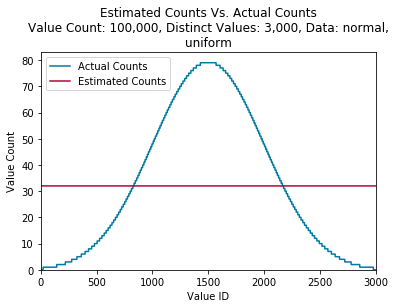

C:\Users\Arne\Anaconda3\lib\site-packages\ipykernel_launcher.py:172: RuntimeWarning: divide by zero encountered in longlong_scalars


max error: 47
max relative error: 3100.0%
Estimation Technique: uniform
Sample Size: 3000
Mean Error: 24.8656666667
Mean Squared Error: 775.522333333
Column Size [kB](uint16_t): 200.0



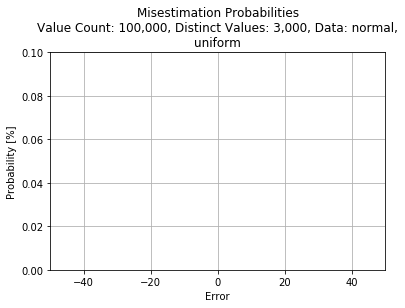

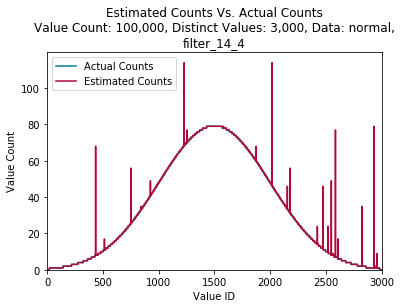

C:\Users\Arne\Anaconda3\lib\site-packages\ipykernel_launcher.py:172: RuntimeWarning: invalid value encountered in longlong_scalars


max error: 78
max relative error: 7800.0%
Estimation Technique: filter_14_4
Sample Size: 3000000
Mean Error: 0.377017
Mean Squared Error: 21.4614176667
Column Size [kB](uint16_t): 200.0



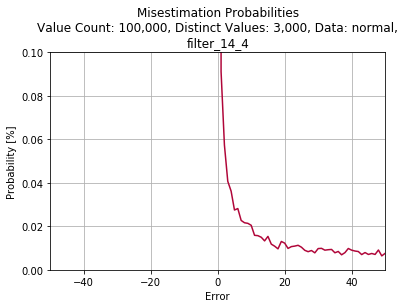

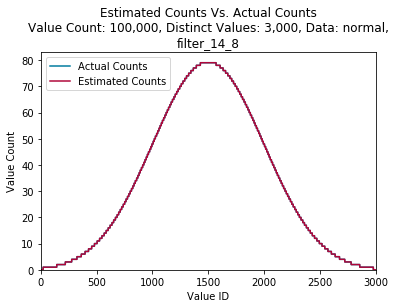

max error: 0
max relative error: 0%
Estimation Technique: filter_14_8
Sample Size: 3000000
Mean Error: 0.0237996666667
Mean Squared Error: 1.35995233333
Column Size [kB](uint16_t): 200.0



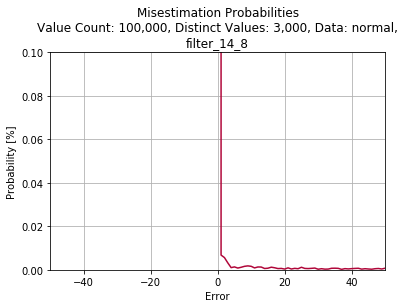

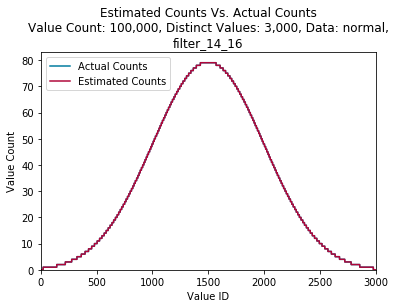

max error: 0
max relative error: 0%
Estimation Technique: filter_14_16
Sample Size: 3000000
Mean Error: 4e-05
Mean Squared Error: 0.00178066666667
Column Size [kB](uint16_t): 200.0



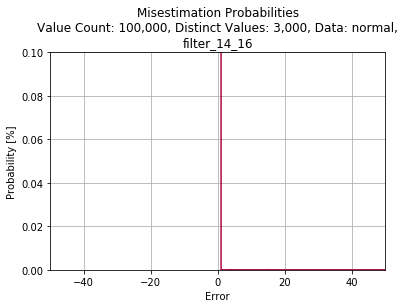

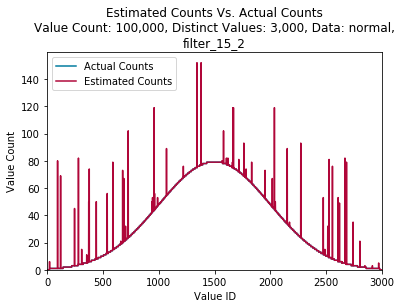

max error: 79
max relative error: 7900.0%
Estimation Technique: filter_15_2
Sample Size: 3000000
Mean Error: 0.753382
Mean Squared Error: 42.9683233333
Column Size [kB](uint16_t): 200.0



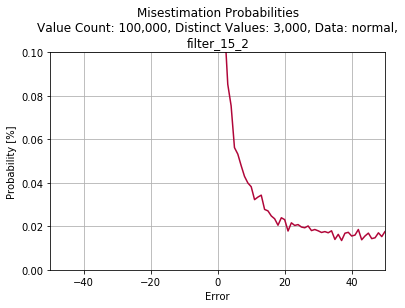

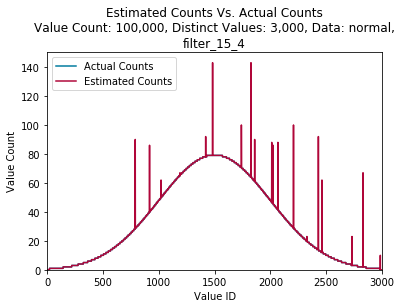

max error: 79
max relative error: 3250.0%
Estimation Technique: filter_15_4
Sample Size: 3000000
Mean Error: 0.188599333333
Mean Squared Error: 10.7550246667
Column Size [kB](uint16_t): 200.0



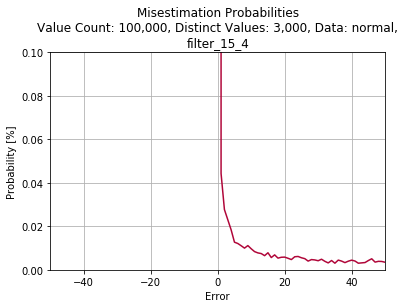

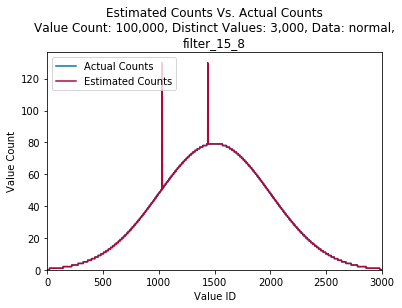

max error: 79
max relative error: 154.901960784%
Estimation Technique: filter_15_8
Sample Size: 3000000
Mean Error: 0.0117866666667
Mean Squared Error: 0.674988666667
Column Size [kB](uint16_t): 200.0



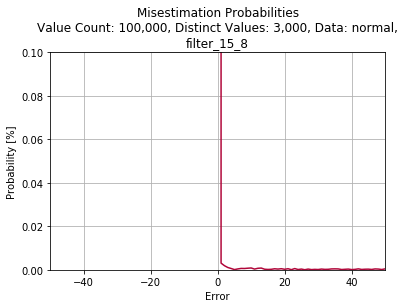

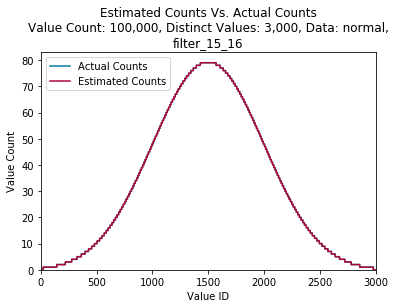

max error: 0
max relative error: 0%
Estimation Technique: filter_15_16
Sample Size: 3000000
Mean Error: 1.8e-05
Mean Squared Error: 0.000838666666667
Column Size [kB](uint16_t): 200.0



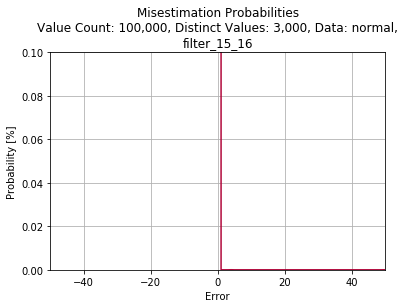

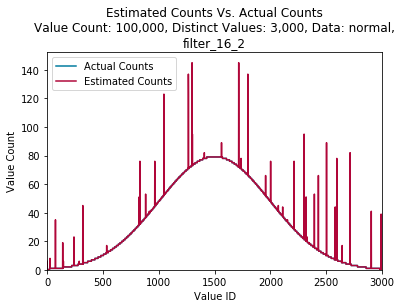

max error: 79
max relative error: 4000.0%
Estimation Technique: filter_16_2
Sample Size: 3000000
Mean Error: 0.374738666667
Mean Squared Error: 21.3300993333
Column Size [kB](uint16_t): 200.0



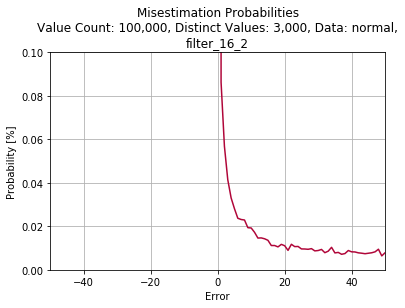

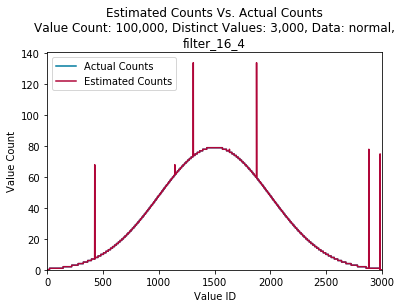

max error: 77
max relative error: 7700.0%
Estimation Technique: filter_16_4
Sample Size: 3000000
Mean Error: 0.091322
Mean Squared Error: 5.164568
Column Size [kB](uint16_t): 200.0



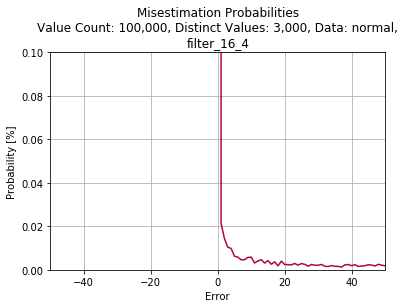

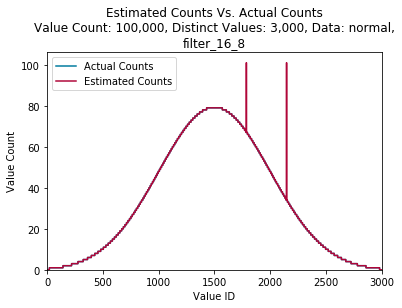

max error: 67
max relative error: 197.058823529%
Estimation Technique: filter_16_8
Sample Size: 3000000
Mean Error: 0.00587466666667
Mean Squared Error: 0.338202
Column Size [kB](uint16_t): 200.0



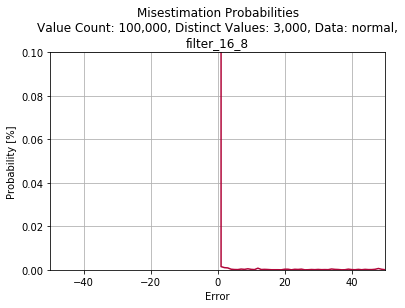

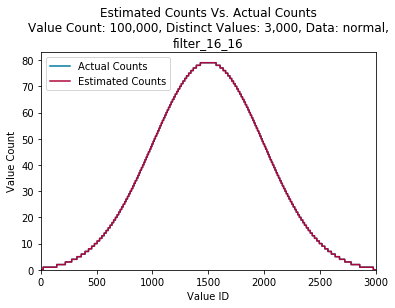

max error: 0
max relative error: 0%
Estimation Technique: filter_16_16
Sample Size: 3000000
Mean Error: 0.000102
Mean Squared Error: 0.00450333333333
Column Size [kB](uint16_t): 200.0



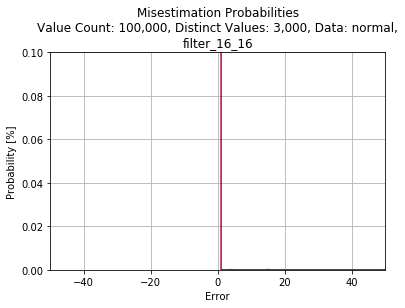

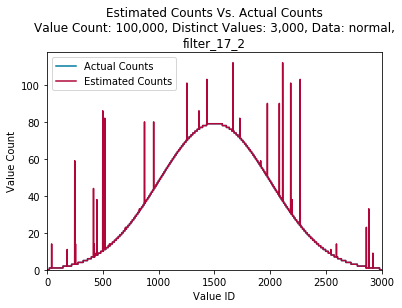

max error: 79
max relative error: 3200.0%
Estimation Technique: filter_17_2
Sample Size: 3000000
Mean Error: 0.187801333333
Mean Squared Error: 10.7292406667
Column Size [kB](uint16_t): 200.0



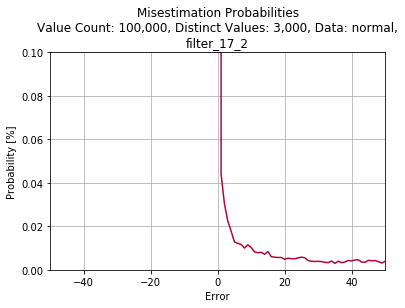

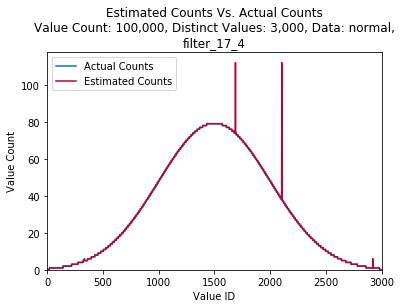

max error: 74
max relative error: 500.0%
Estimation Technique: filter_17_4
Sample Size: 3000000
Mean Error: 0.0534863333333
Mean Squared Error: 3.06493966667
Column Size [kB](uint16_t): 200.0



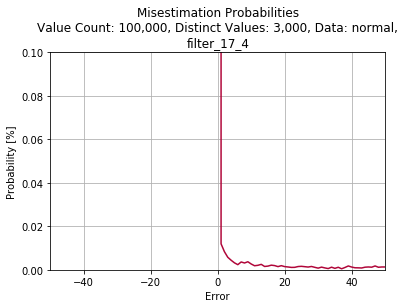

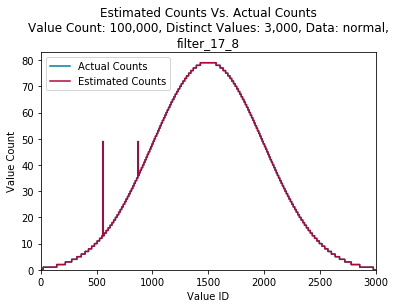

max error: 36
max relative error: 276.923076923%
Estimation Technique: filter_17_8
Sample Size: 3000000
Mean Error: 0.002956
Mean Squared Error: 0.158867333333
Column Size [kB](uint16_t): 200.0



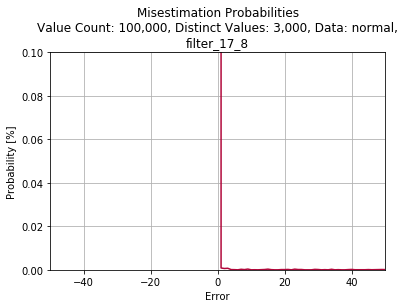

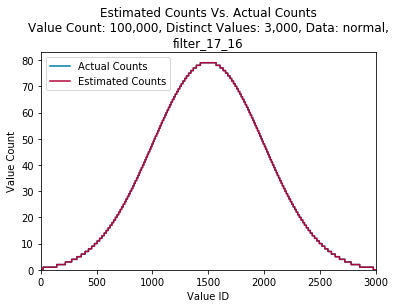

max error: 0
max relative error: 0%
Estimation Technique: filter_17_16
Sample Size: 3000000
Mean Error: 0.00016
Mean Squared Error: 0.00712266666667
Column Size [kB](uint16_t): 200.0



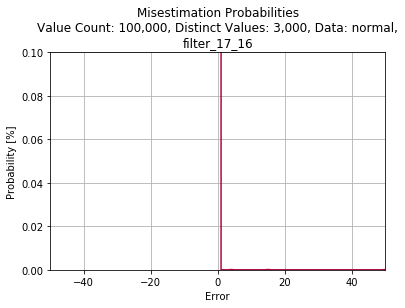

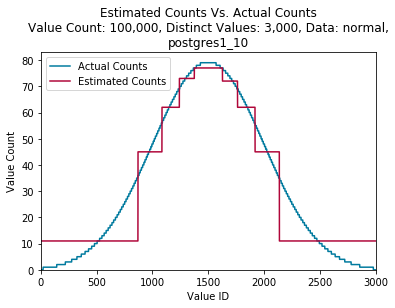

max error: 25
max relative error: 1000.0%
Estimation Technique: postgres1_10
Sample Size: 3000
Mean Error: 6.331
Mean Squared Error: 66.339
Column Size [kB](uint16_t): 200.0



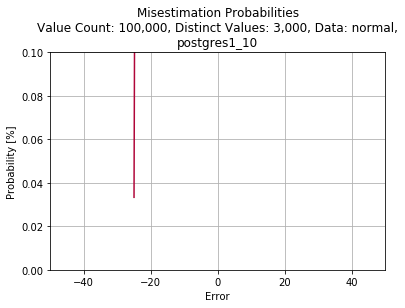

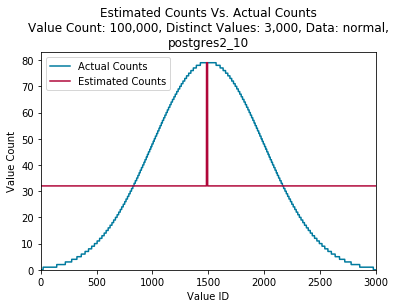

max error: 47
max relative error: 3100.0%
Estimation Technique: postgres2_10
Sample Size: 3000
Mean Error: 24.709
Mean Squared Error: 768.159
Column Size [kB](uint16_t): 200.0



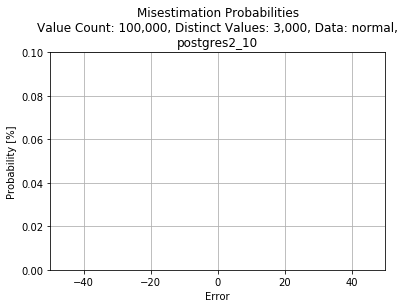

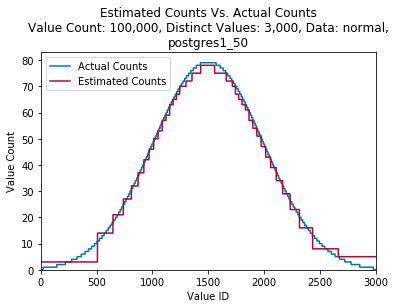

max error: 8
max relative error: 400.0%
Estimation Technique: postgres1_50
Sample Size: 3000
Mean Error: 1.92833333333
Mean Squared Error: 5.569
Column Size [kB](uint16_t): 200.0



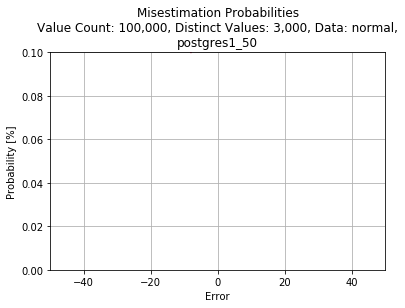

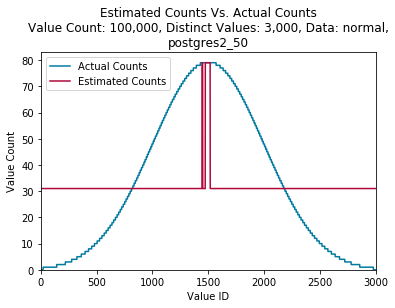

max error: 48
max relative error: 3000.0%
Estimation Technique: postgres2_50
Sample Size: 3000
Mean Error: 23.9663333333
Mean Squared Error: 739.608333333
Column Size [kB](uint16_t): 200.0



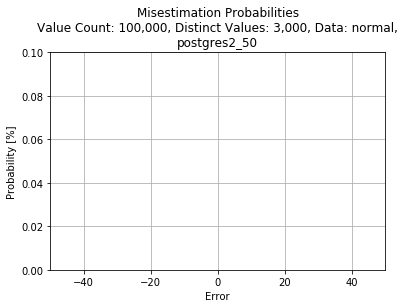

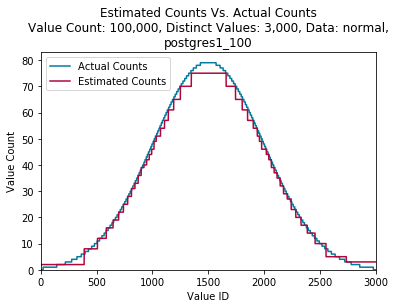

max error: 6
max relative error: 200.0%
Estimation Technique: postgres1_100
Sample Size: 3000
Mean Error: 1.701
Mean Squared Error: 4.51633333333
Column Size [kB](uint16_t): 200.0



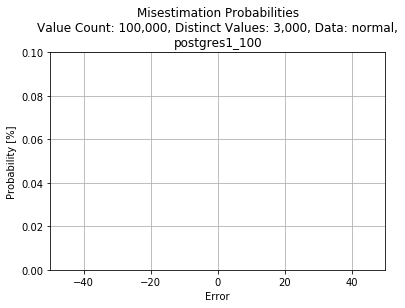

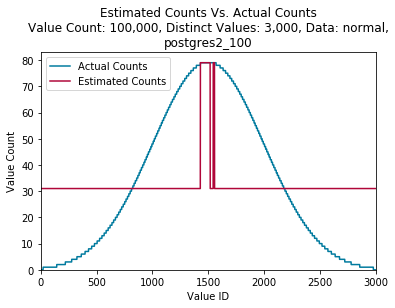

max error: 48
max relative error: 3000.0%
Estimation Technique: postgres2_100
Sample Size: 3000
Mean Error: 23.1663333333
Mean Squared Error: 701.208333333
Column Size [kB](uint16_t): 200.0



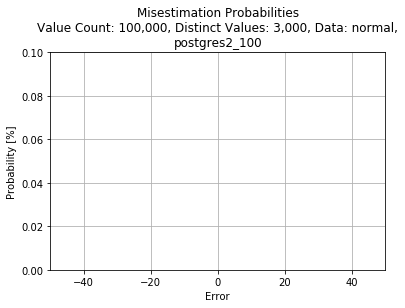

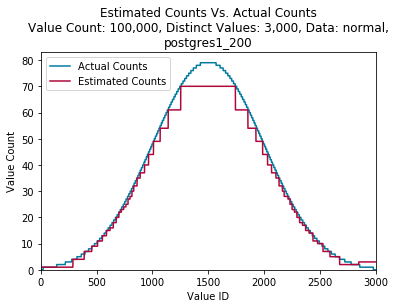

max error: 9
max relative error: 200.0%
Estimation Technique: postgres1_200
Sample Size: 3000
Mean Error: 2.539
Mean Squared Error: 12.9923333333
Column Size [kB](uint16_t): 200.0



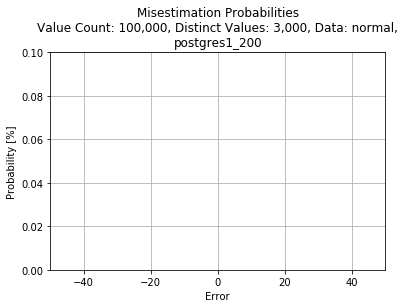

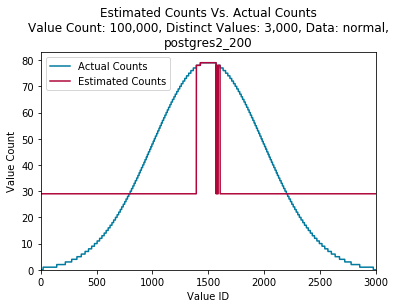

max error: 49
max relative error: 2800.0%
Estimation Technique: postgres2_200
Sample Size: 3000
Mean Error: 21.302
Mean Squared Error: 624.260666667
Column Size [kB](uint16_t): 200.0



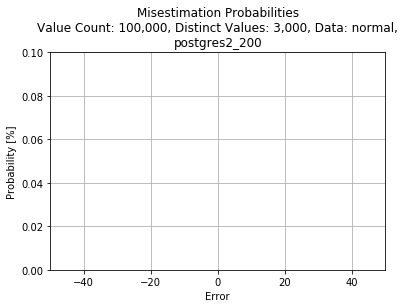

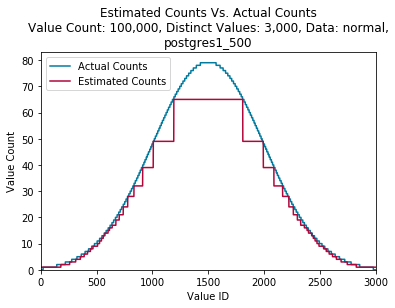

max error: 16
max relative error: 50.0%
Estimation Technique: postgres1_500
Sample Size: 3000
Mean Error: 3.96933333333
Mean Squared Error: 37.2013333333
Column Size [kB](uint16_t): 200.0



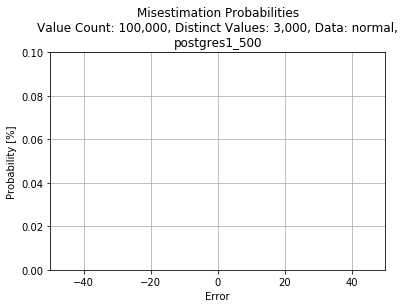

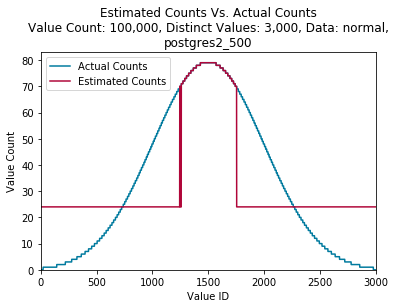

max error: 46
max relative error: 2300.0%
Estimation Technique: postgres2_500
Sample Size: 3000
Mean Error: 15.848
Mean Squared Error: 398.416666667
Column Size [kB](uint16_t): 200.0



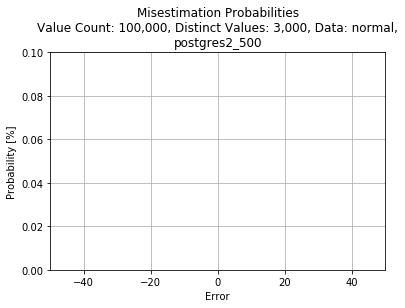

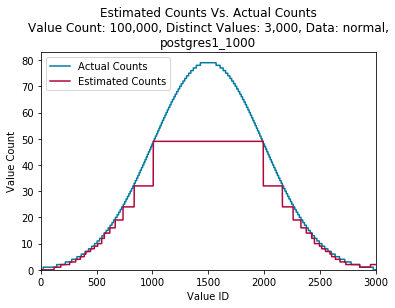

max error: 30
max relative error: 100.0%
Estimation Technique: postgres1_1000
Sample Size: 3000
Mean Error: 8.01766666667
Mean Squared Error: 161.659666667
Column Size [kB](uint16_t): 200.0



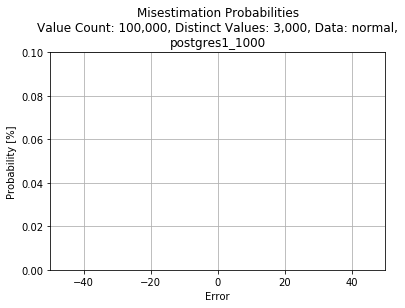

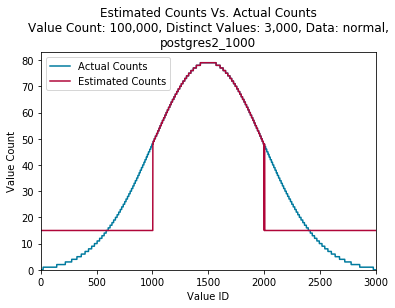

max error: 33
max relative error: 1400.0%
Estimation Technique: postgres2_1000
Sample Size: 3000
Mean Error: 7.93933333333
Mean Squared Error: 130.826666667
Column Size [kB](uint16_t): 200.0



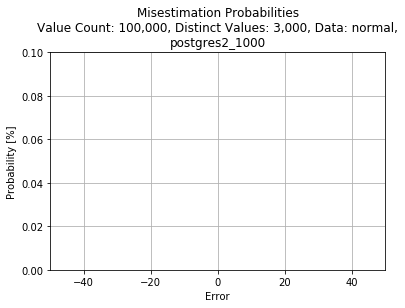

Estimation Technique  Memory Consumption [Byte]  Mean Error  \
0               uniform                        4.0   24.865667   
1          postgres1_10                       40.0   24.846667   
2          postgres1_50                      200.0   24.839667   
3         postgres1_100                      400.0   24.245000   
4          postgres2_10                       40.0   24.709000   
5          postgres2_50                      200.0   23.966333   
6         postgres2_100                      400.0   23.166333   
7           filter_14_4                    12288.0    0.377215   
8           filter_14_8                    20480.0    0.025324   
9          filter_14_16                    36864.0    0.000215   
10          filter_15_2                    16384.0    0.751808   
11          filter_15_4                    24576.0    0.188443   
12          filter_15_8                    40960.0    0.012400   
13         filter_15_16                    73728.0    0.000165   
14          filter_16_2                    32768.0    0.372522   
15          filter_16_4                    49152.0    0.091282   
16          filter_16_8                    81920.0    0.006012   
17         filter_16_16                   147456.0    0.000107   
18          filter_17_2                    65536.0    0.183888   
19          filter_17_4                    98304.0    0.049104   
20          filter_17_8                   163840.0    0.002846   
21         filter_17_16                   294912.0    0.000075   

    Mean Squared Error  
0           775.522333  
1           773.792667  
2           795.842333  
3           755.104333  
4           768.159000  
5           739.608333  
6           701.208333  
7            21.485537  
8             1.434645  
9             0.014979  
10           42.895548  
11           10.810421  
12            0.712565  
13            0.011317  
14           21.113064  
15            5.187572  
16            0.344481  
17            0.007489  
18           10.468288  
19            2.789270  
20            0.157857  
21            0.004161

Estimation Technique  Memory Consumption [Byte]  Mean Error  \
0           filter_14_4                    12288.0    0.377215   
1           filter_14_8                    20480.0    0.025324   
2          filter_14_16                    36864.0    0.000215   
3           filter_15_2                    16384.0    0.751808   
4           filter_15_4                    24576.0    0.188443   
5           filter_15_8                    40960.0    0.012400   
6          filter_15_16                    73728.0    0.000165   
7           filter_16_2                    32768.0    0.372522   
8           filter_16_4                    49152.0    0.091282   
9           filter_16_8                    81920.0    0.006012   
10         filter_16_16                   147456.0    0.000107   
11          filter_17_2                    65536.0    0.183888   
12          filter_17_4                    98304.0    0.049104   
13          filter_17_8                   163840.0    0.002846   
14         filter_17_16                   294912.0    0.000075   

    Mean Squared Error  
0            21.485537  
1             1.434645  
2             0.014979  
3            42.895548  
4            10.810421  
5             0.712565  
6             0.011317  
7            21.113064  
8             5.187572  
9             0.344481  
10            0.007489  
11           10.468288  
12            2.789270  
13            0.157857  
14            0.004161

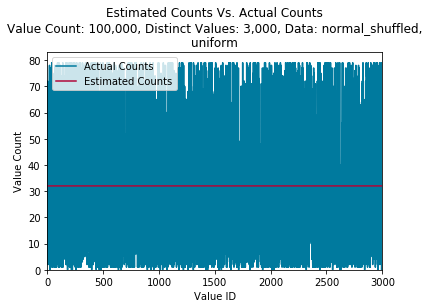

max error: 47
max relative error: 3100.0%
Estimation Technique: uniform
Sample Size: 3000
Mean Error: 24.8656666667
Mean Squared Error: 775.522333333
Column Size [kB](uint16_t): 200.0



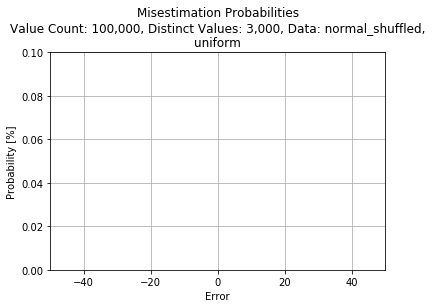

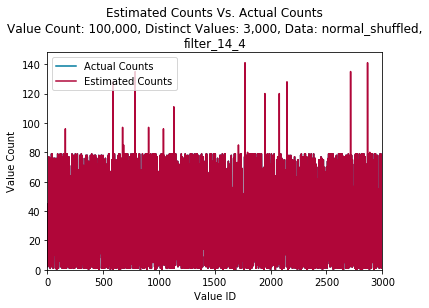

max error: 79
max relative error: 7900.0%
Estimation Technique: filter_14_4
Sample Size: 3000000
Mean Error: 0.377215
Mean Squared Error: 21.485537
Column Size [kB](uint16_t): 200.0



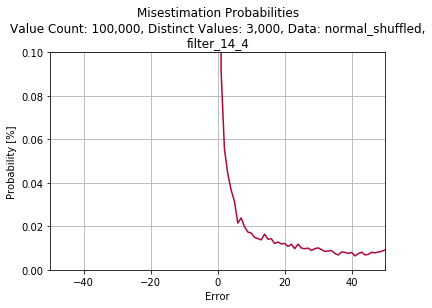

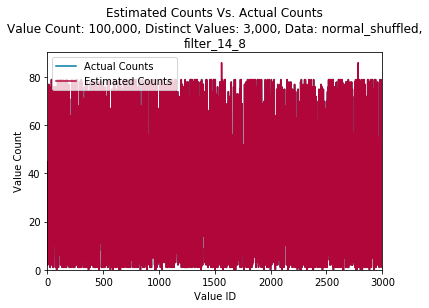

max error: 69
max relative error: 405.882352941%
Estimation Technique: filter_14_8
Sample Size: 3000000
Mean Error: 0.025324
Mean Squared Error: 1.43464466667
Column Size [kB](uint16_t): 200.0



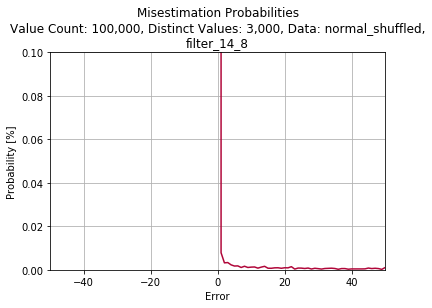

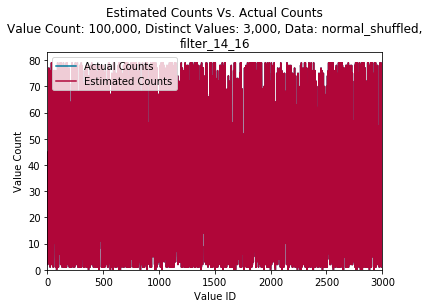

max error: 0
max relative error: 0%
Estimation Technique: filter_14_16
Sample Size: 3000000
Mean Error: 0.000214666666667
Mean Squared Error: 0.0149786666667
Column Size [kB](uint16_t): 200.0



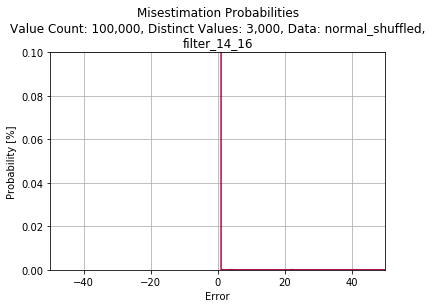

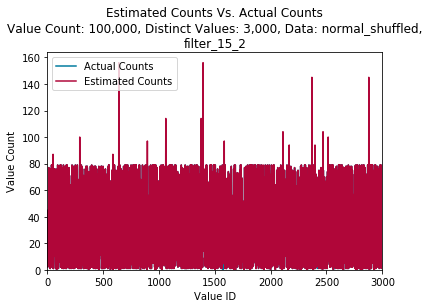

max error: 79
max relative error: 6800.0%
Estimation Technique: filter_15_2
Sample Size: 3000000
Mean Error: 0.751808333333
Mean Squared Error: 42.8955476667
Column Size [kB](uint16_t): 200.0



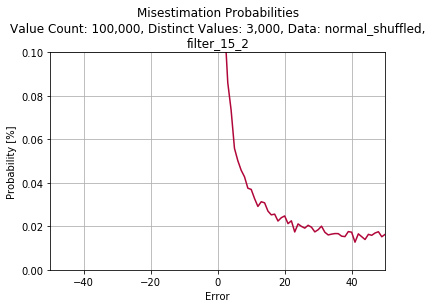

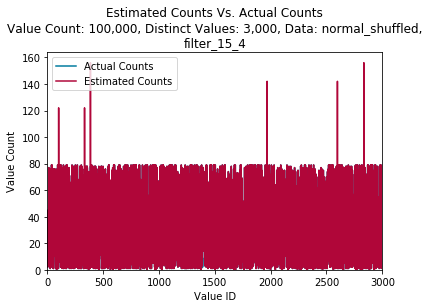

max error: 78
max relative error: 3200.0%
Estimation Technique: filter_15_4
Sample Size: 3000000
Mean Error: 0.188442666667
Mean Squared Error: 10.8104213333
Column Size [kB](uint16_t): 200.0



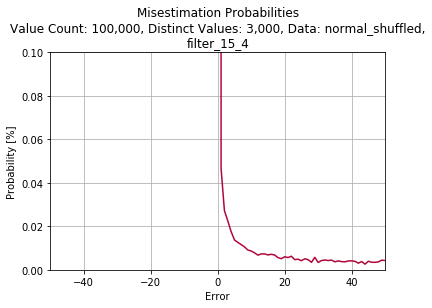

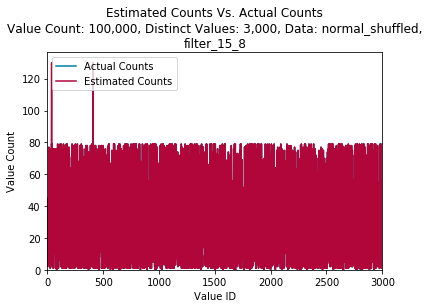

max error: 76
max relative error: 140.740740741%
Estimation Technique: filter_15_8
Sample Size: 3000000
Mean Error: 0.0124003333333
Mean Squared Error: 0.712565
Column Size [kB](uint16_t): 200.0



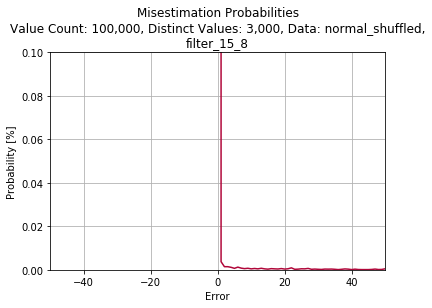

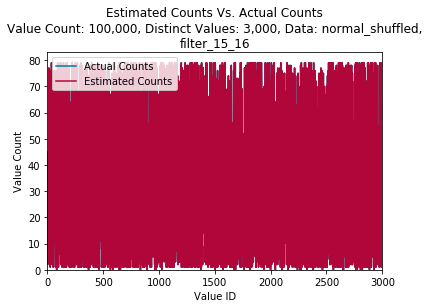

max error: 0
max relative error: 0%
Estimation Technique: filter_15_16
Sample Size: 3000000
Mean Error: 0.000165333333333
Mean Squared Error: 0.0113173333333
Column Size [kB](uint16_t): 200.0



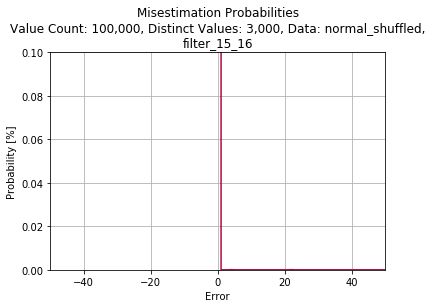

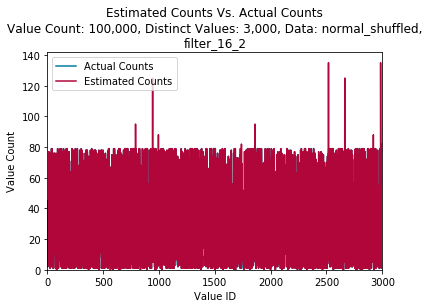

max error: 79
max relative error: 3700.0%
Estimation Technique: filter_16_2
Sample Size: 3000000
Mean Error: 0.372522333333
Mean Squared Error: 21.1130643333
Column Size [kB](uint16_t): 200.0



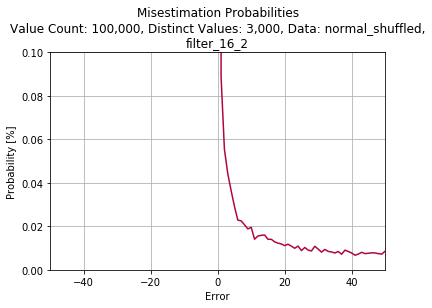

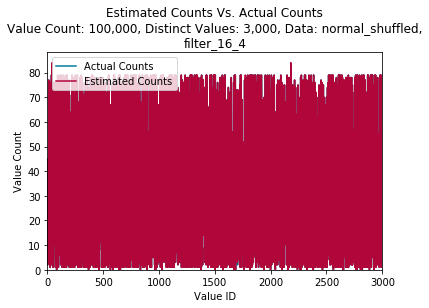

max error: 78
max relative error: 3850.0%
Estimation Technique: filter_16_4
Sample Size: 3000000
Mean Error: 0.0912816666667
Mean Squared Error: 5.18757233333
Column Size [kB](uint16_t): 200.0



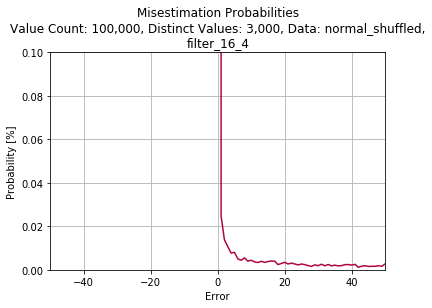

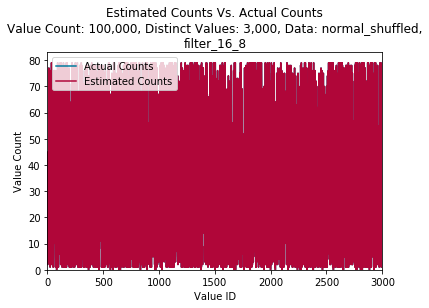

max error: 0
max relative error: 0%
Estimation Technique: filter_16_8
Sample Size: 3000000
Mean Error: 0.006012
Mean Squared Error: 0.344480666667
Column Size [kB](uint16_t): 200.0



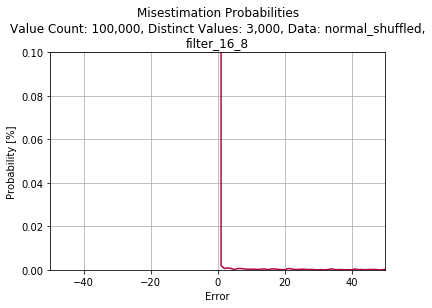

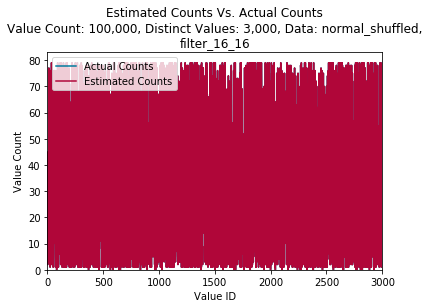

max error: 0
max relative error: 0%
Estimation Technique: filter_16_16
Sample Size: 3000000
Mean Error: 0.000107333333333
Mean Squared Error: 0.00748933333333
Column Size [kB](uint16_t): 200.0



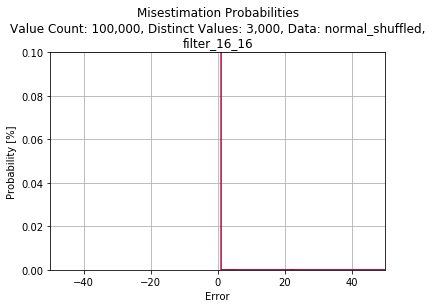

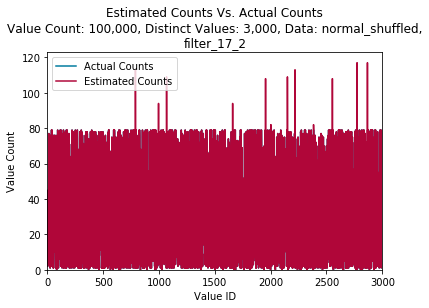

max error: 79
max relative error: 2633.33333333%
Estimation Technique: filter_17_2
Sample Size: 3000000
Mean Error: 0.183888333333
Mean Squared Error: 10.4682883333
Column Size [kB](uint16_t): 200.0



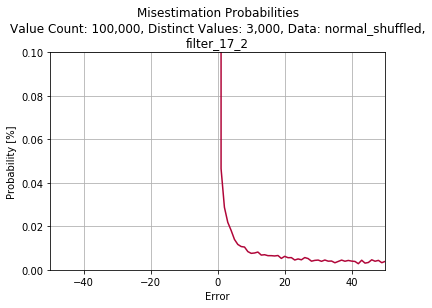

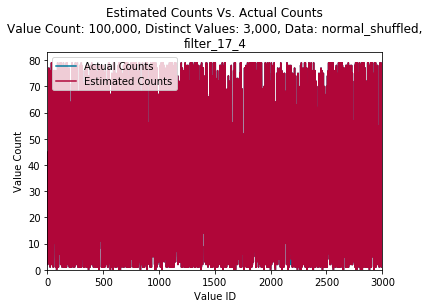

max error: 4
max relative error: 200.0%
Estimation Technique: filter_17_4
Sample Size: 3000000
Mean Error: 0.0491043333333
Mean Squared Error: 2.78926966667
Column Size [kB](uint16_t): 200.0



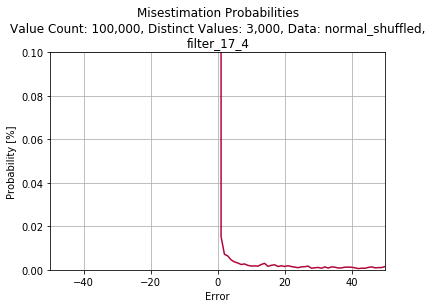

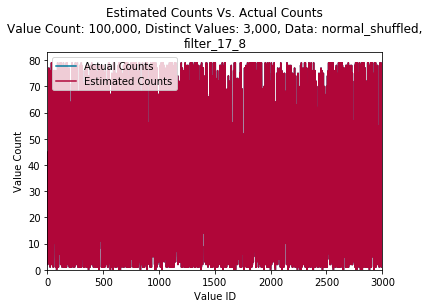

max error: 7
max relative error: 175.0%
Estimation Technique: filter_17_8
Sample Size: 3000000
Mean Error: 0.002846
Mean Squared Error: 0.157857333333
Column Size [kB](uint16_t): 200.0



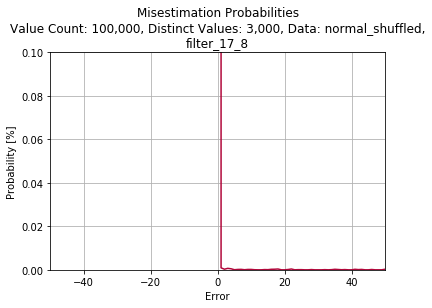

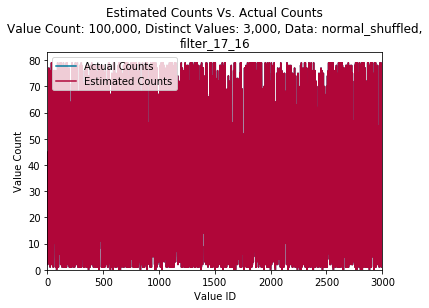

max error: 0
max relative error: 0%
Estimation Technique: filter_17_16
Sample Size: 3000000
Mean Error: 7.53333333333e-05
Mean Squared Error: 0.00416133333333
Column Size [kB](uint16_t): 200.0



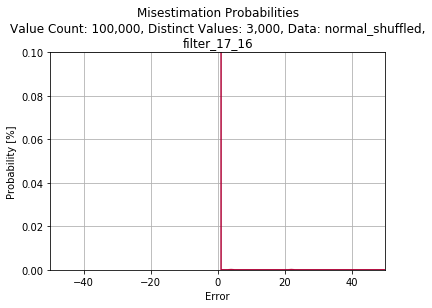

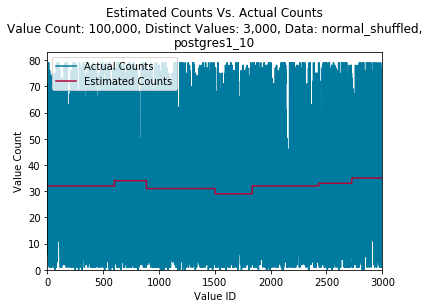

max error: 50
max relative error: 3400.0%
Estimation Technique: postgres1_10
Sample Size: 3000
Mean Error: 24.8466666667
Mean Squared Error: 773.792666667
Column Size [kB](uint16_t): 200.0



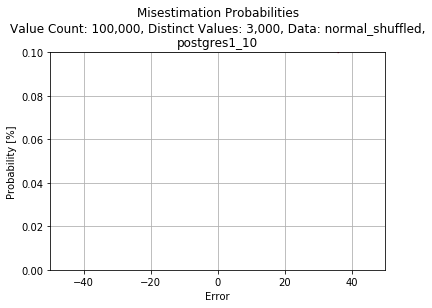

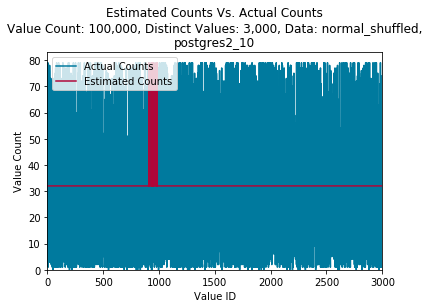

max error: 47
max relative error: 3100.0%
Estimation Technique: postgres2_10
Sample Size: 3000
Mean Error: 24.709
Mean Squared Error: 768.159
Column Size [kB](uint16_t): 200.0



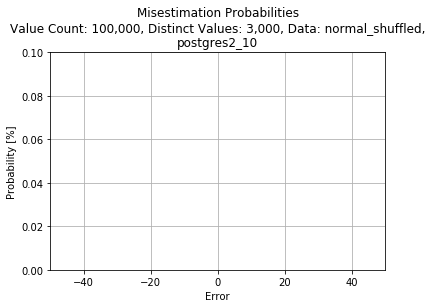

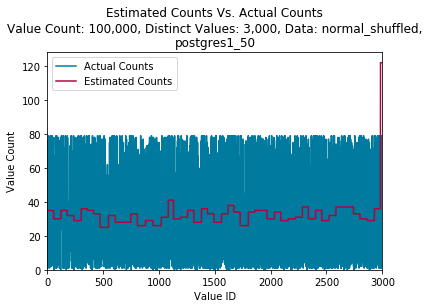

max error: 121
max relative error: 12100.0%
Estimation Technique: postgres1_50
Sample Size: 3000
Mean Error: 24.8396666667
Mean Squared Error: 795.842333333
Column Size [kB](uint16_t): 200.0



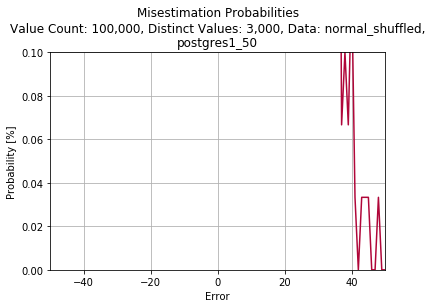

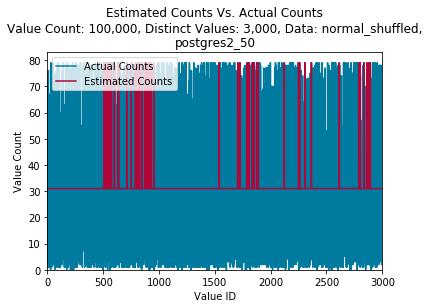

max error: 48
max relative error: 3000.0%
Estimation Technique: postgres2_50
Sample Size: 3000
Mean Error: 23.9663333333
Mean Squared Error: 739.608333333
Column Size [kB](uint16_t): 200.0



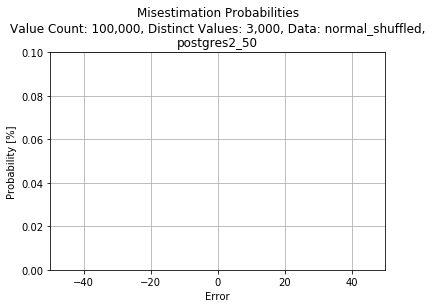

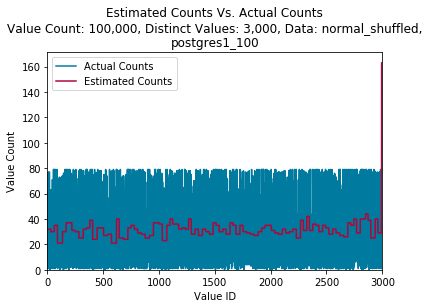

max error: 162
max relative error: 16200.0%
Estimation Technique: postgres1_100
Sample Size: 3000
Mean Error: 24.245
Mean Squared Error: 755.104333333
Column Size [kB](uint16_t): 200.0



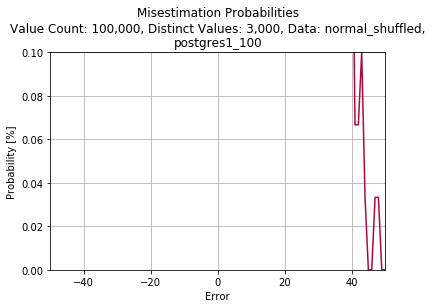

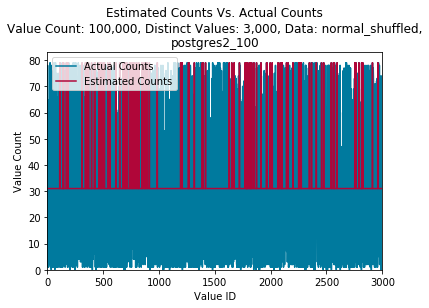

max error: 48
max relative error: 3000.0%
Estimation Technique: postgres2_100
Sample Size: 3000
Mean Error: 23.1663333333
Mean Squared Error: 701.208333333
Column Size [kB](uint16_t): 200.0



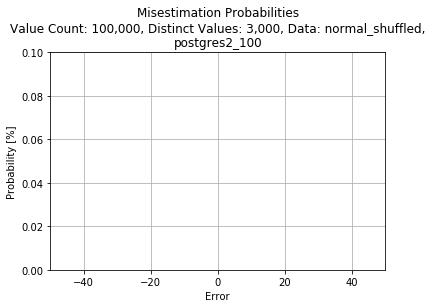

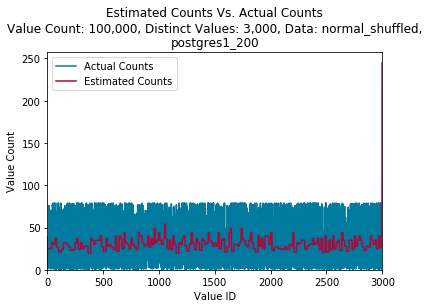

max error: 171
max relative error: 4300.0%
Estimation Technique: postgres1_200
Sample Size: 3000
Mean Error: 23.4
Mean Squared Error: 727.02
Column Size [kB](uint16_t): 200.0



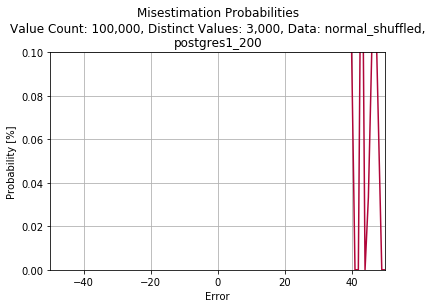

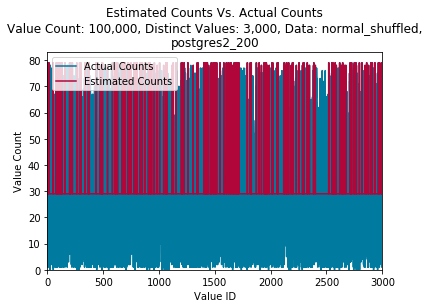

max error: 49
max relative error: 2800.0%
Estimation Technique: postgres2_200
Sample Size: 3000
Mean Error: 21.302
Mean Squared Error: 624.260666667
Column Size [kB](uint16_t): 200.0



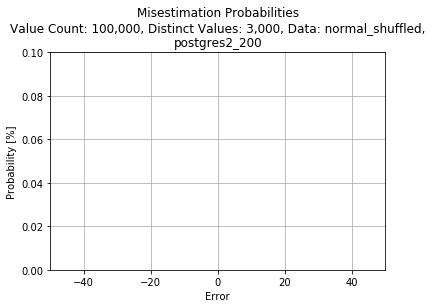

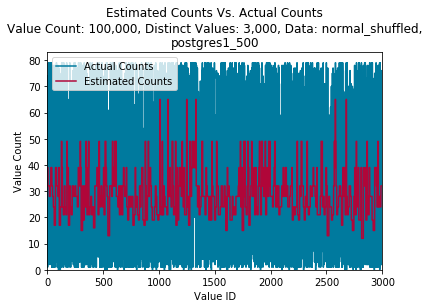

max error: 64
max relative error: 4800.0%
Estimation Technique: postgres1_500
Sample Size: 3000
Mean Error: 22.0976666667
Mean Squared Error: 684.512333333
Column Size [kB](uint16_t): 200.0



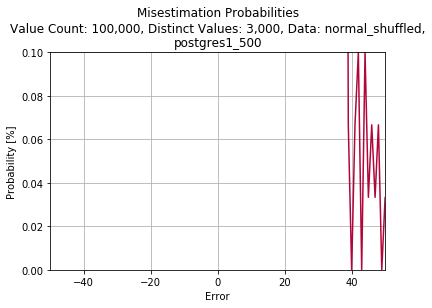

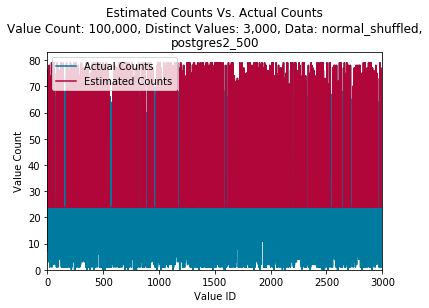

max error: 46
max relative error: 2300.0%
Estimation Technique: postgres2_500
Sample Size: 3000
Mean Error: 15.848
Mean Squared Error: 398.416666667
Column Size [kB](uint16_t): 200.0



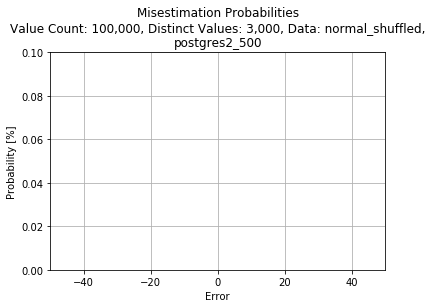

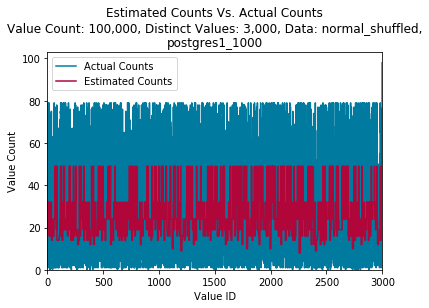

max error: 96
max relative error: 4800.0%
Estimation Technique: postgres1_1000
Sample Size: 3000
Mean Error: 21.1486666667
Mean Squared Error: 679.643333333
Column Size [kB](uint16_t): 200.0



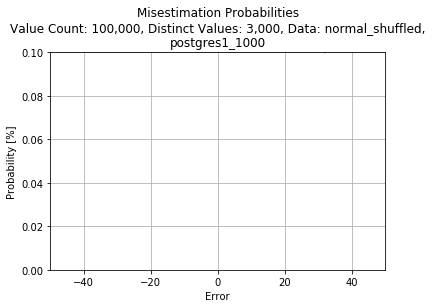

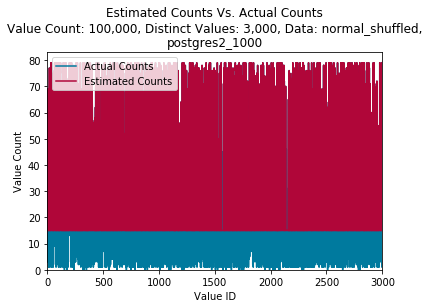

max error: 33
max relative error: 1400.0%
Estimation Technique: postgres2_1000
Sample Size: 3000
Mean Error: 7.93933333333
Mean Squared Error: 130.826666667
Column Size [kB](uint16_t): 200.0



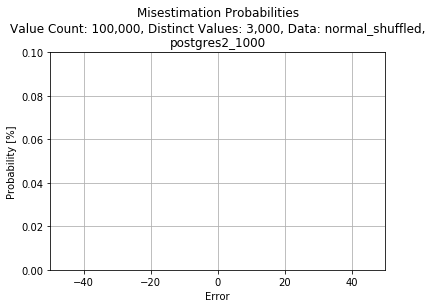

Estimation Technique  Memory Consumption [Byte]  Mean Error  \
0               uniform                        4.0   33.858333   
1          postgres1_10                       40.0    4.590667   
2          postgres1_50                      200.0    2.625000   
3         postgres1_100                      400.0    3.609000   
4          postgres2_10                       40.0   28.356667   
5          postgres2_50                      200.0   19.026667   
6         postgres2_100                      400.0   13.921000   
7           filter_14_4                    12288.0    0.382915   
8           filter_14_8                    20480.0    0.028436   
9          filter_14_16                    36864.0    0.000078   
10          filter_15_2                    16384.0    0.747989   
11          filter_15_4                    24576.0    0.190194   
12          filter_15_8                    40960.0    0.013214   
13         filter_15_16                    73728.0    0.000059   
14          filter_16_2                    32768.0    0.373439   
15          filter_16_4                    49152.0    0.096454   
16          filter_16_8                    81920.0    0.008744   
17         filter_16_16                   147456.0    0.000054   
18          filter_17_2                    65536.0    0.183981   
19          filter_17_4                    98304.0    0.049790   
20          filter_17_8                   163840.0    0.004079   
21         filter_17_16                   294912.0    0.000054   

    Mean Squared Error  
0          8194.794333  
1           247.644667  
2           358.069667  
3           568.384333  
4          4099.660667  
5          1167.632667  
6           530.070333  
7           109.469391  
8             7.971946  
9             0.003468  
10          208.416308  
11           54.903948  
12            4.137235  
13            0.002370  
14          102.053003  
15           25.449393  
16            3.408725  
17            0.002327  
18           48.356940  
19           14.172968  
20            1.347136  
21            0.002327

Estimation Technique  Memory Consumption [Byte]  Mean Error  \
0           filter_14_4                    12288.0    0.382915   
1           filter_14_8                    20480.0    0.028436   
2          filter_14_16                    36864.0    0.000078   
3           filter_15_2                    16384.0    0.747989   
4           filter_15_4                    24576.0    0.190194   
5           filter_15_8                    40960.0    0.013214   
6          filter_15_16                    73728.0    0.000059   
7           filter_16_2                    32768.0    0.373439   
8           filter_16_4                    49152.0    0.096454   
9           filter_16_8                    81920.0    0.008744   
10         filter_16_16                   147456.0    0.000054   
11          filter_17_2                    65536.0    0.183981   
12          filter_17_4                    98304.0    0.049790   
13          filter_17_8                   163840.0    0.004079   
14         filter_17_16                   294912.0    0.000054   

    Mean Squared Error  
0           109.469391  
1             7.971946  
2             0.003468  
3           208.416308  
4            54.903948  
5             4.137235  
6             0.002370  
7           102.053003  
8            25.449393  
9             3.408725  
10            0.002327  
11           48.356940  
12           14.172968  
13            1.347136  
14            0.002327

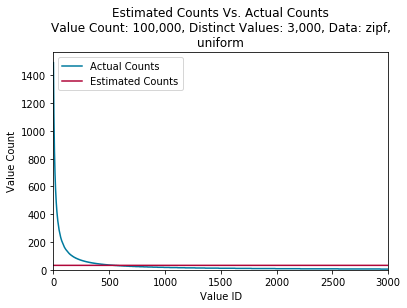

max error: 1459
max relative error: 540.0%
Estimation Technique: uniform
Sample Size: 3000
Mean Error: 33.8583333333
Mean Squared Error: 8194.79433333
Column Size [kB](uint16_t): 200.0



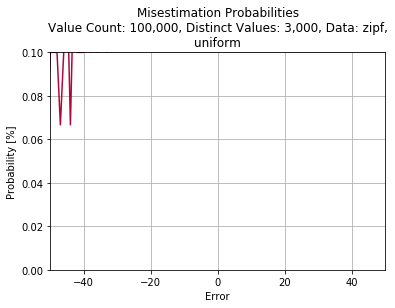

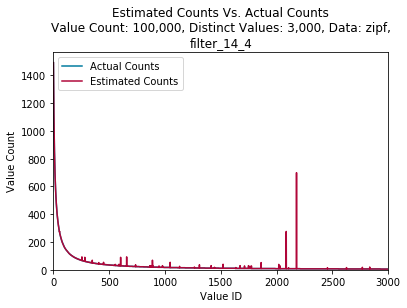

max error: 691
max relative error: 8637.5%
Estimation Technique: filter_14_4
Sample Size: 3000000
Mean Error: 0.382914666667
Mean Squared Error: 109.469391333
Column Size [kB](uint16_t): 200.0



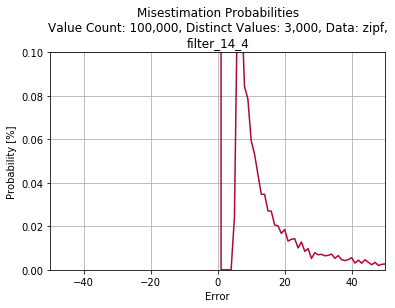

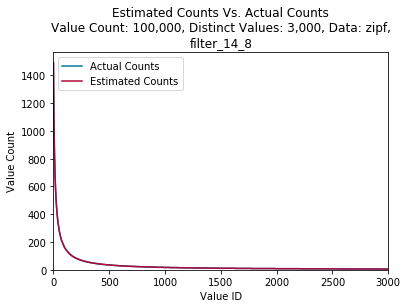

max error: 0
max relative error: 0%
Estimation Technique: filter_14_8
Sample Size: 3000000
Mean Error: 0.0284356666667
Mean Squared Error: 7.97194633333
Column Size [kB](uint16_t): 200.0



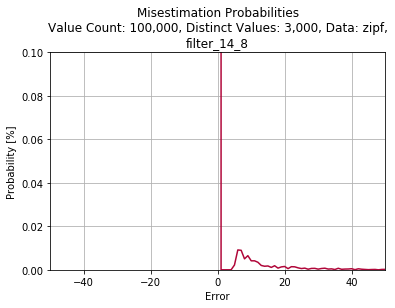

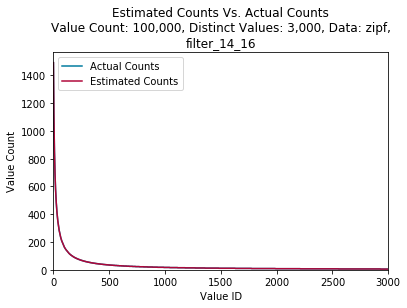

max error: 0
max relative error: 0%
Estimation Technique: filter_14_16
Sample Size: 3000000
Mean Error: 7.83333333333e-05
Mean Squared Error: 0.00346833333333
Column Size [kB](uint16_t): 200.0



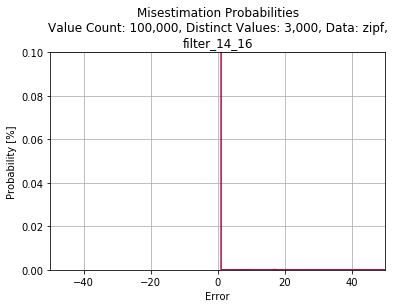

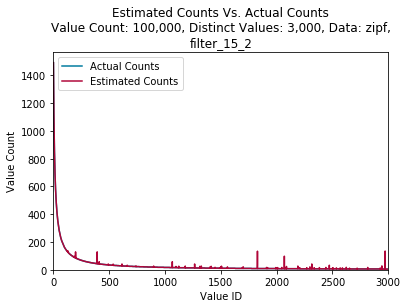

max error: 130
max relative error: 2600.0%
Estimation Technique: filter_15_2
Sample Size: 3000000
Mean Error: 0.747988666667
Mean Squared Error: 208.416308
Column Size [kB](uint16_t): 200.0



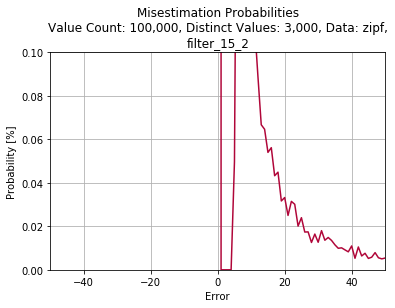

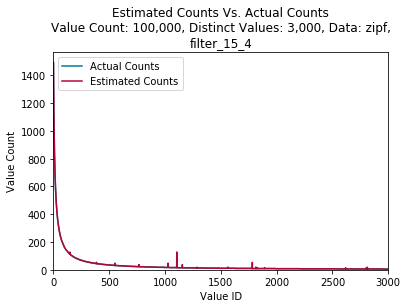

max error: 112
max relative error: 700.0%
Estimation Technique: filter_15_4
Sample Size: 3000000
Mean Error: 0.190194333333
Mean Squared Error: 54.9039483333
Column Size [kB](uint16_t): 200.0



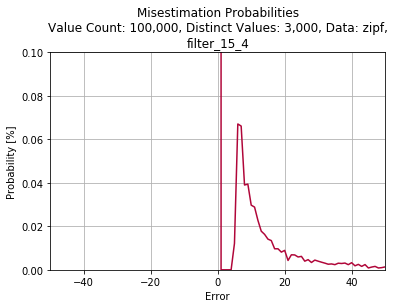

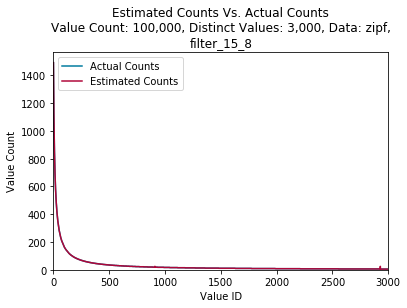

max error: 19
max relative error: 316.666666667%
Estimation Technique: filter_15_8
Sample Size: 3000000
Mean Error: 0.0132143333333
Mean Squared Error: 4.137235
Column Size [kB](uint16_t): 200.0



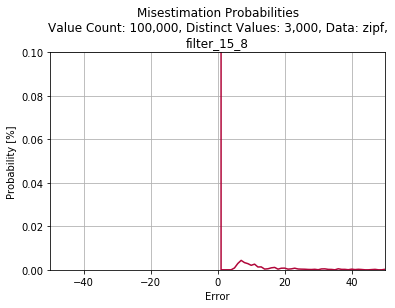

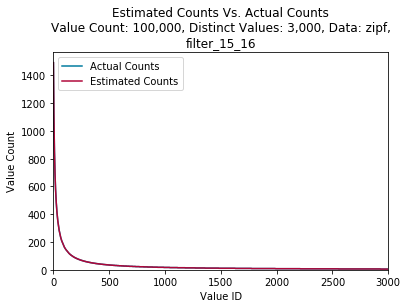

max error: 0
max relative error: 0%
Estimation Technique: filter_15_16
Sample Size: 3000000
Mean Error: 5.93333333333e-05
Mean Squared Error: 0.00237
Column Size [kB](uint16_t): 200.0



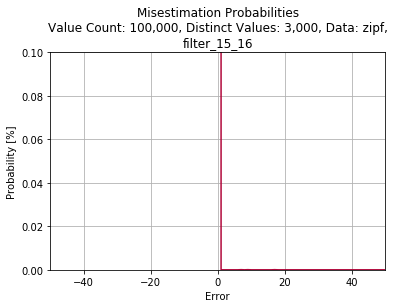

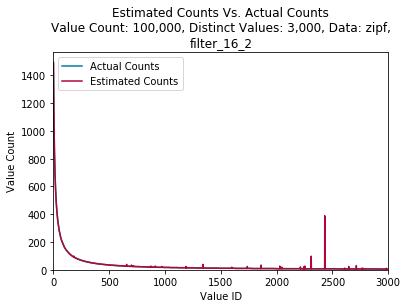

max error: 382
max relative error: 5457.14285714%
Estimation Technique: filter_16_2
Sample Size: 3000000
Mean Error: 0.373439333333
Mean Squared Error: 102.053002667
Column Size [kB](uint16_t): 200.0



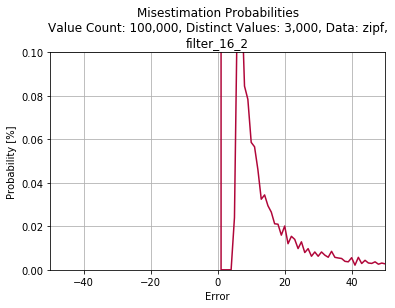

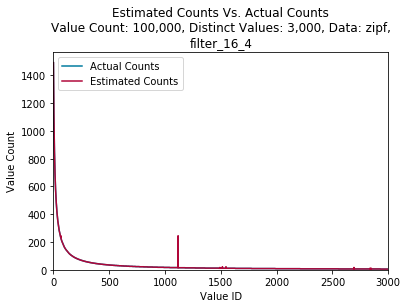

max error: 230
max relative error: 1533.33333333%
Estimation Technique: filter_16_4
Sample Size: 3000000
Mean Error: 0.0964543333333
Mean Squared Error: 25.449393
Column Size [kB](uint16_t): 200.0



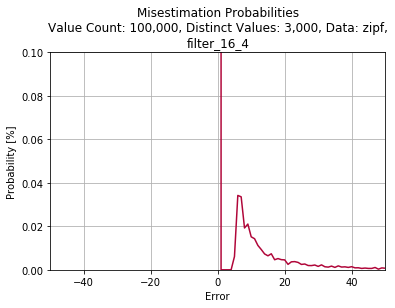

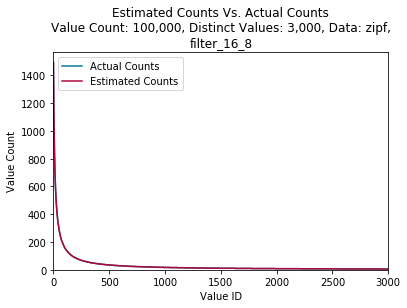

max error: 0
max relative error: 0%
Estimation Technique: filter_16_8
Sample Size: 3000000
Mean Error: 0.00874433333333
Mean Squared Error: 3.408725
Column Size [kB](uint16_t): 200.0



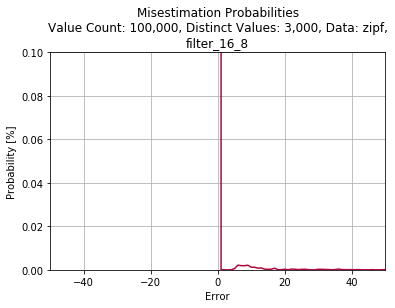

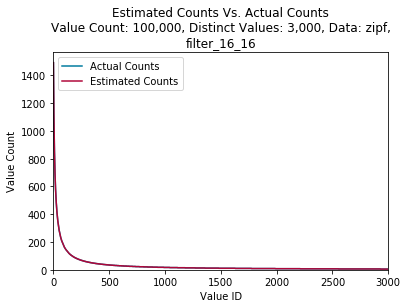

max error: 0
max relative error: 0%
Estimation Technique: filter_16_16
Sample Size: 3000000
Mean Error: 5.4e-05
Mean Squared Error: 0.00232666666667
Column Size [kB](uint16_t): 200.0



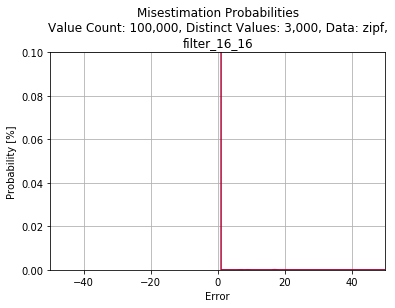

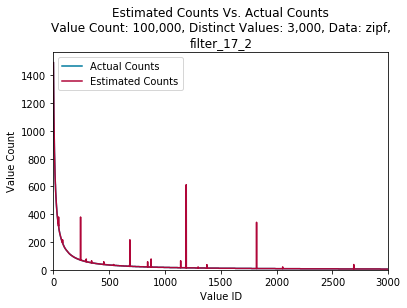

max error: 599
max relative error: 4278.57142857%
Estimation Technique: filter_17_2
Sample Size: 3000000
Mean Error: 0.183980666667
Mean Squared Error: 48.35694
Column Size [kB](uint16_t): 200.0



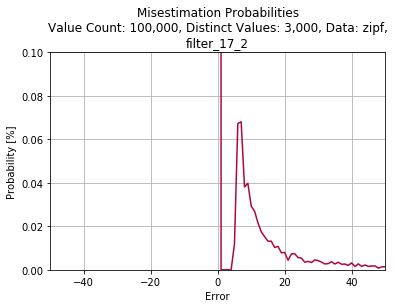

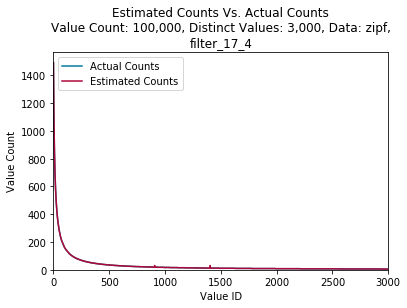

max error: 19
max relative error: 158.333333333%
Estimation Technique: filter_17_4
Sample Size: 3000000
Mean Error: 0.0497903333333
Mean Squared Error: 14.1729676667
Column Size [kB](uint16_t): 200.0



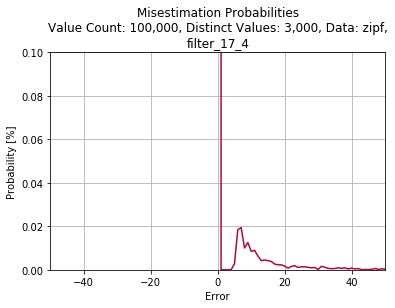

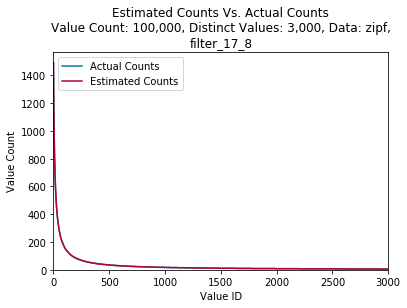

max error: 0
max relative error: 0%
Estimation Technique: filter_17_8
Sample Size: 3000000
Mean Error: 0.00407866666667
Mean Squared Error: 1.347136
Column Size [kB](uint16_t): 200.0



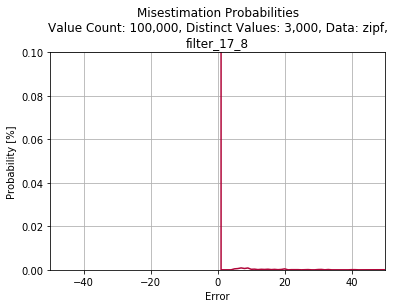

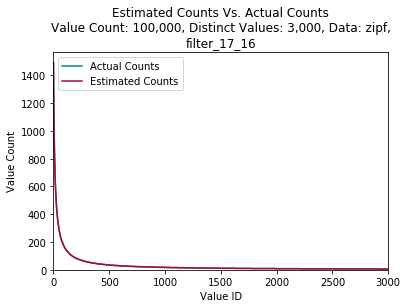

max error: 0
max relative error: 0%
Estimation Technique: filter_17_16
Sample Size: 3000000
Mean Error: 5.4e-05
Mean Squared Error: 0.00232666666667
Column Size [kB](uint16_t): 200.0



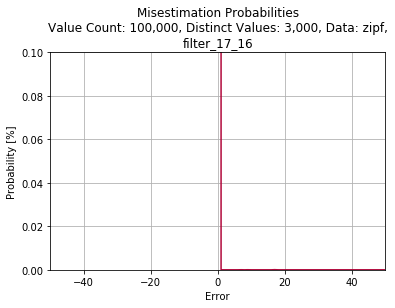

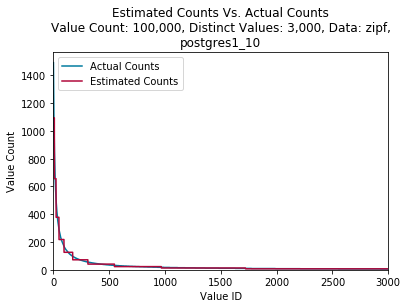

max error: 397
max relative error: 40.0%
Estimation Technique: postgres1_10
Sample Size: 3000
Mean Error: 4.59066666667
Mean Squared Error: 247.644666667
Column Size [kB](uint16_t): 200.0



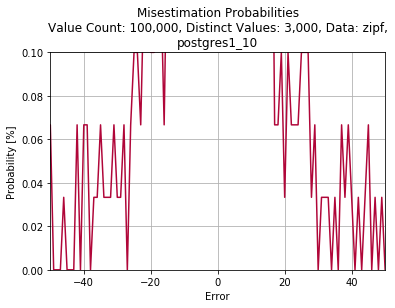

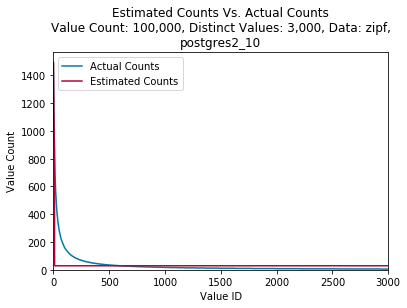

max error: 787
max relative error: 480.0%
Estimation Technique: postgres2_10
Sample Size: 3000
Mean Error: 28.3566666667
Mean Squared Error: 4099.66066667
Column Size [kB](uint16_t): 200.0



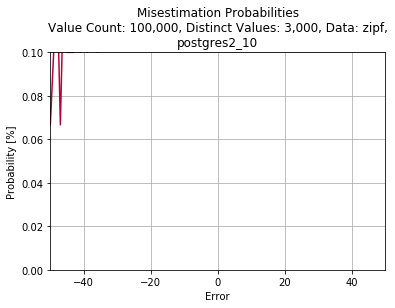

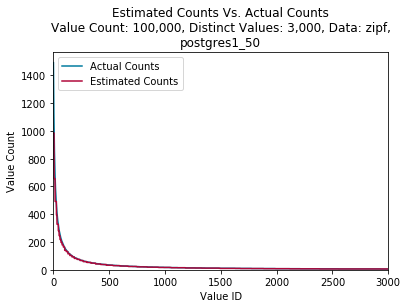

max error: 506
max relative error: 34.1365461847%
Estimation Technique: postgres1_50
Sample Size: 3000
Mean Error: 2.625
Mean Squared Error: 358.069666667
Column Size [kB](uint16_t): 200.0



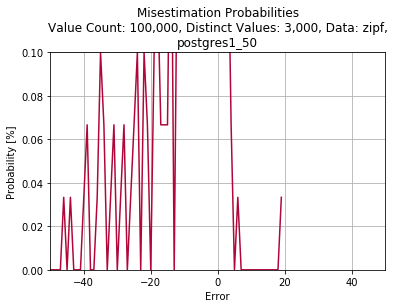

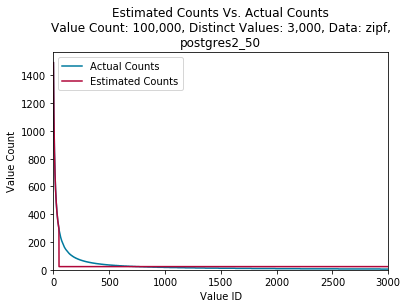

max error: 267
max relative error: 360.0%
Estimation Technique: postgres2_50
Sample Size: 3000
Mean Error: 19.0266666667
Mean Squared Error: 1167.63266667
Column Size [kB](uint16_t): 200.0



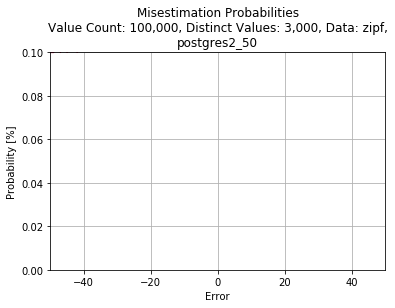

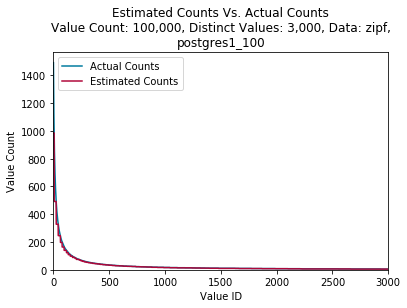

max error: 506
max relative error: 47.8813559322%
Estimation Technique: postgres1_100
Sample Size: 3000
Mean Error: 3.609
Mean Squared Error: 568.384333333
Column Size [kB](uint16_t): 200.0



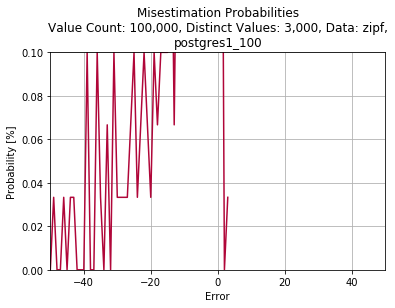

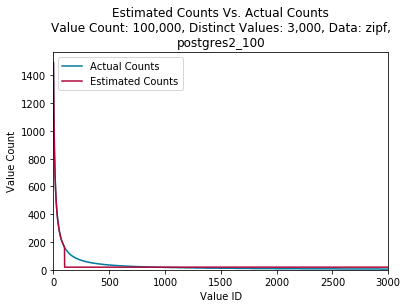

max error: 141
max relative error: 280.0%
Estimation Technique: postgres2_100
Sample Size: 3000
Mean Error: 13.921
Mean Squared Error: 530.070333333
Column Size [kB](uint16_t): 200.0



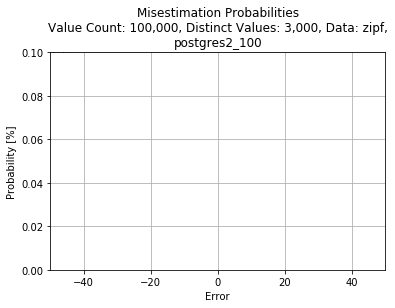

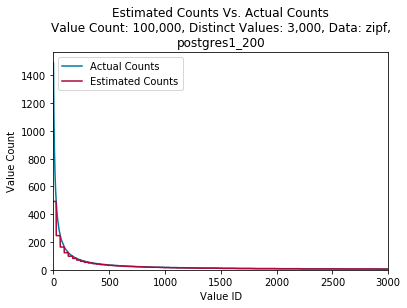

max error: 999
max relative error: 67.0020120724%
Estimation Technique: postgres1_200
Sample Size: 3000
Mean Error: 5.82766666667
Mean Squared Error: 1803.72766667
Column Size [kB](uint16_t): 200.0



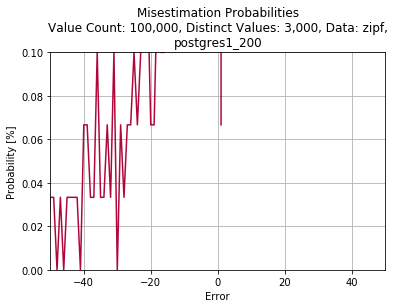

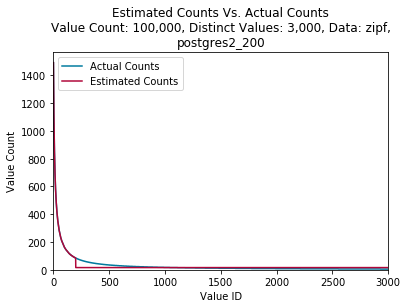

max error: 68
max relative error: 220.0%
Estimation Technique: postgres2_200
Sample Size: 3000
Mean Error: 9.50233333333
Mean Squared Error: 203.437666667
Column Size [kB](uint16_t): 200.0



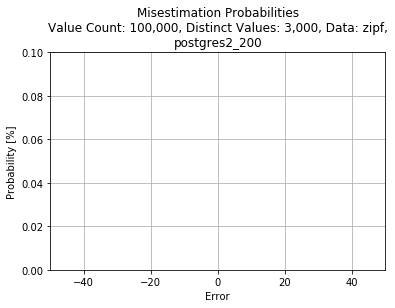

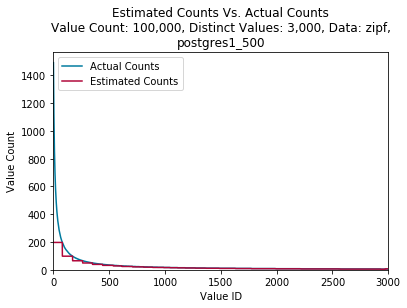

max error: 1294
max relative error: 86.7873910127%
Estimation Technique: postgres1_500
Sample Size: 3000
Mean Error: 10.1666666667
Mean Squared Error: 4376.00933333
Column Size [kB](uint16_t): 200.0



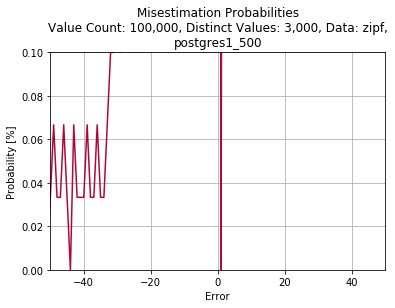

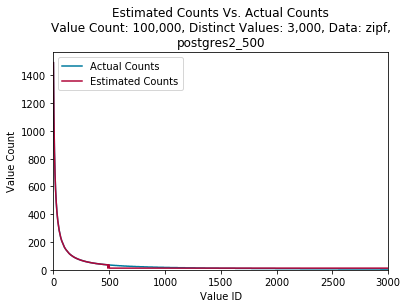

max error: 23
max relative error: 140.0%
Estimation Technique: postgres2_500
Sample Size: 3000
Mean Error: 4.467
Mean Squared Error: 39.6796666667
Column Size [kB](uint16_t): 200.0



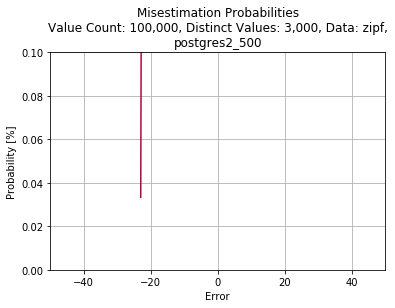

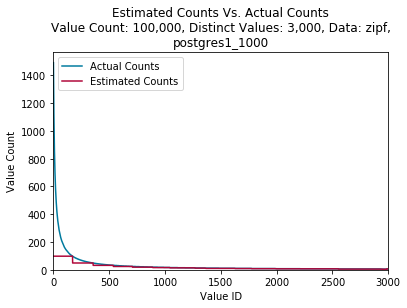

max error: 1393
max relative error: 93.4272300469%
Estimation Technique: postgres1_1000
Sample Size: 3000
Mean Error: 13.5903333333
Mean Squared Error: 6080.01833333
Column Size [kB](uint16_t): 200.0



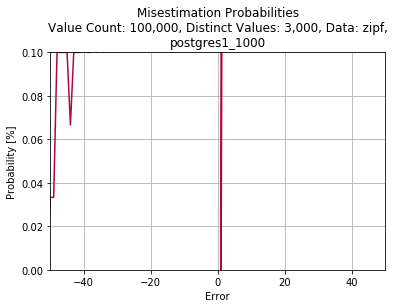

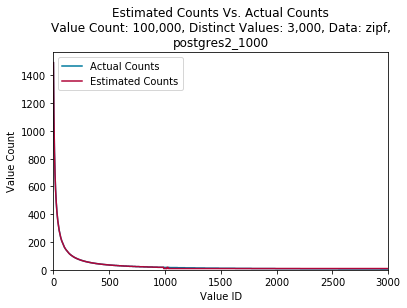

max error: 8
max relative error: 80.0%
Estimation Technique: postgres2_1000
Sample Size: 3000
Mean Error: 1.72033333333
Mean Squared Error: 6.71433333333
Column Size [kB](uint16_t): 200.0



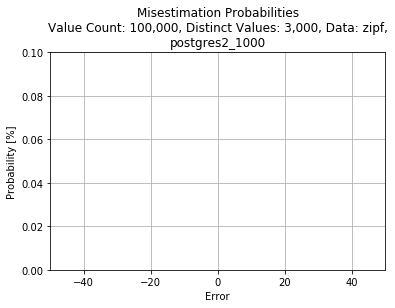

Estimation Technique  Memory Consumption [Byte]  Mean Error  \
0               uniform                        4.0   33.858333   
1          postgres1_10                       40.0   34.080333   
2          postgres1_50                      200.0   32.965333   
3         postgres1_100                      400.0   31.612333   
4          postgres2_10                       40.0   28.356667   
5          postgres2_50                      200.0   19.026667   
6         postgres2_100                      400.0   13.921000   
7           filter_14_4                    12288.0    0.381450   
8           filter_14_8                    20480.0    0.033072   
9          filter_14_16                    36864.0    0.000171   
10          filter_15_2                    16384.0    0.747042   
11          filter_15_4                    24576.0    0.190001   
12          filter_15_8                    40960.0    0.017474   
13         filter_15_16                    73728.0    0.000076   
14          filter_16_2                    32768.0    0.367611   
15          filter_16_4                    49152.0    0.100940   
16          filter_16_8                    81920.0    0.006123   
17         filter_16_16                   147456.0    0.000057   
18          filter_17_2                    65536.0    0.193060   
19          filter_17_4                    98304.0    0.059881   
20          filter_17_8                   163840.0    0.002123   
21         filter_17_16                   294912.0    0.000095   

    Mean Squared Error  
0          8194.794333  
1          8169.018333  
2          8112.737333  
3          8000.259000  
4          4099.660667  
5          1167.632667  
6           530.070333  
7           106.726542  
8            13.858326  
9             0.006045  
10          215.069027  
11           54.776070  
12           10.476465  
13            0.002220  
14           98.294444  
15           31.734216  
16            2.288474  
17            0.002015  
18           59.205974  
19           22.950004  
20            0.194924  
21            0.003125

Estimation Technique  Memory Consumption [Byte]  Mean Error  \
0           filter_14_4                    12288.0    0.381450   
1           filter_14_8                    20480.0    0.033072   
2          filter_14_16                    36864.0    0.000171   
3           filter_15_2                    16384.0    0.747042   
4           filter_15_4                    24576.0    0.190001   
5           filter_15_8                    40960.0    0.017474   
6          filter_15_16                    73728.0    0.000076   
7           filter_16_2                    32768.0    0.367611   
8           filter_16_4                    49152.0    0.100940   
9           filter_16_8                    81920.0    0.006123   
10         filter_16_16                   147456.0    0.000057   
11          filter_17_2                    65536.0    0.193060   
12          filter_17_4                    98304.0    0.059881   
13          filter_17_8                   163840.0    0.002123   
14         filter_17_16                   294912.0    0.000095   

    Mean Squared Error  
0           106.726542  
1            13.858326  
2             0.006045  
3           215.069027  
4            54.776070  
5            10.476465  
6             0.002220  
7            98.294444  
8            31.734216  
9             2.288474  
10            0.002015  
11           59.205974  
12           22.950004  
13            0.194924  
14            0.003125

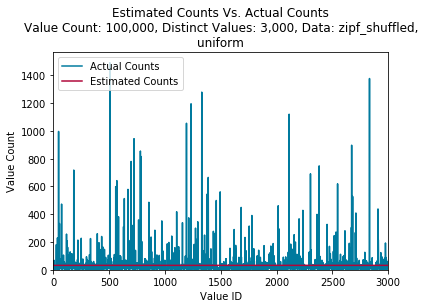

max error: 1459
max relative error: 540.0%
Estimation Technique: uniform
Sample Size: 3000
Mean Error: 33.8583333333
Mean Squared Error: 8194.79433333
Column Size [kB](uint16_t): 200.0



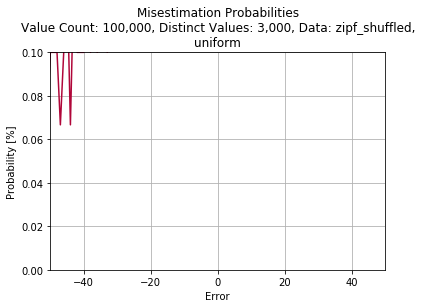

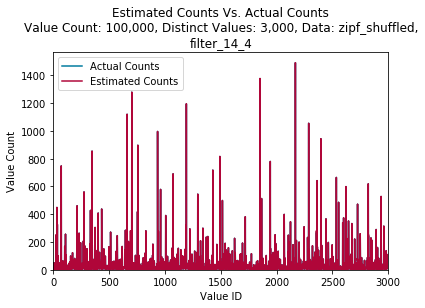

max error: 268
max relative error: 2430.0%
Estimation Technique: filter_14_4
Sample Size: 3000000
Mean Error: 0.381450333333
Mean Squared Error: 106.726542333
Column Size [kB](uint16_t): 200.0



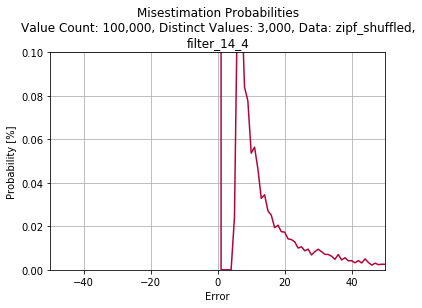

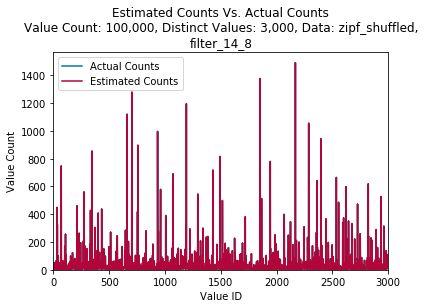

max error: 10
max relative error: 166.666666667%
Estimation Technique: filter_14_8
Sample Size: 3000000
Mean Error: 0.0330723333333
Mean Squared Error: 13.8583263333
Column Size [kB](uint16_t): 200.0



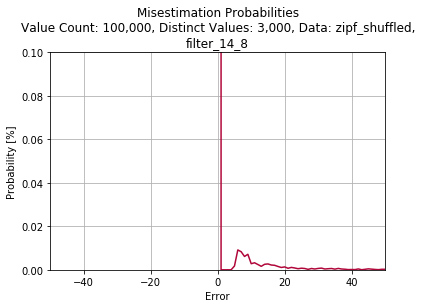

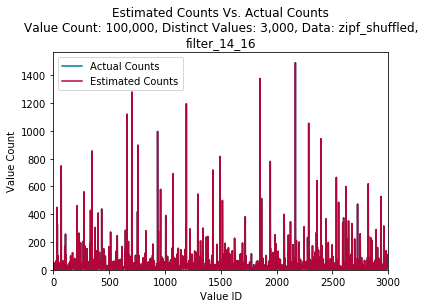

max error: 0
max relative error: 0%
Estimation Technique: filter_14_16
Sample Size: 3000000
Mean Error: 0.000171
Mean Squared Error: 0.006045
Column Size [kB](uint16_t): 200.0



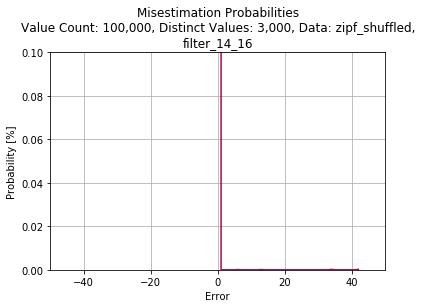

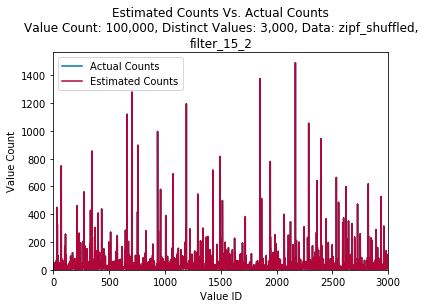

max error: 222
max relative error: 2122.22222222%
Estimation Technique: filter_15_2
Sample Size: 3000000
Mean Error: 0.747041666667
Mean Squared Error: 215.069027
Column Size [kB](uint16_t): 200.0



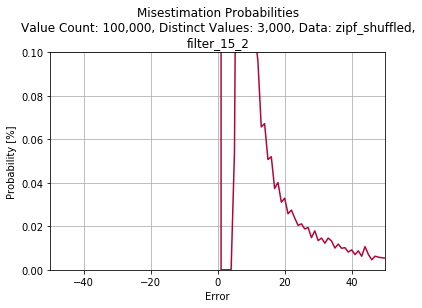

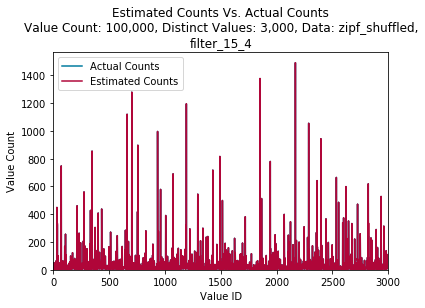

max error: 327
max relative error: 3633.33333333%
Estimation Technique: filter_15_4
Sample Size: 3000000
Mean Error: 0.190000666667
Mean Squared Error: 54.77607
Column Size [kB](uint16_t): 200.0



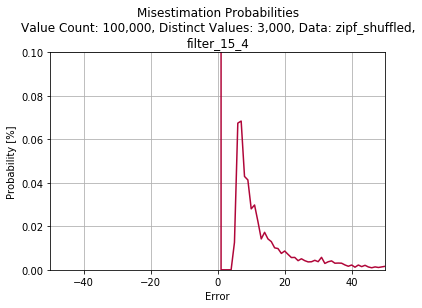

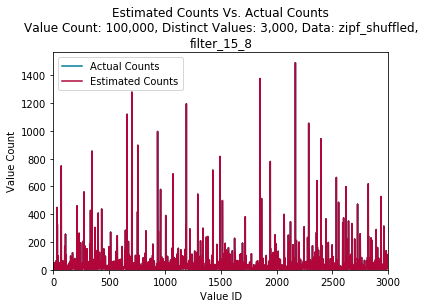

max error: 16
max relative error: 200.0%
Estimation Technique: filter_15_8
Sample Size: 3000000
Mean Error: 0.0174743333333
Mean Squared Error: 10.476465
Column Size [kB](uint16_t): 200.0



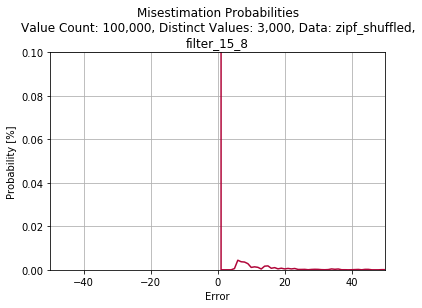

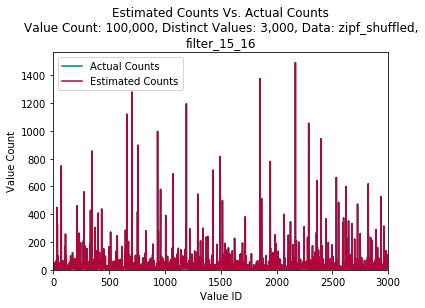

max error: 0
max relative error: 0%
Estimation Technique: filter_15_16
Sample Size: 3000000
Mean Error: 7.6e-05
Mean Squared Error: 0.00222
Column Size [kB](uint16_t): 200.0



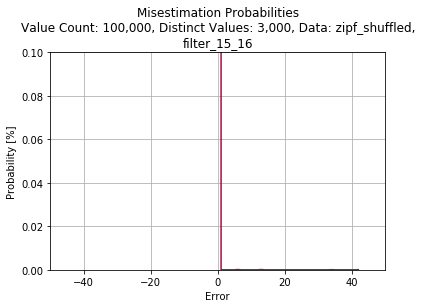

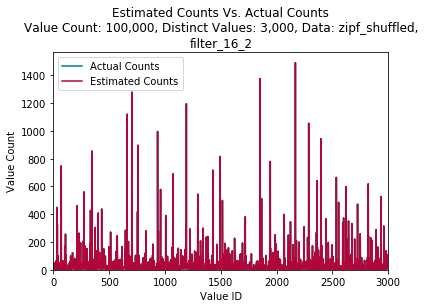

max error: 157
max relative error: 1962.5%
Estimation Technique: filter_16_2
Sample Size: 3000000
Mean Error: 0.367610666667
Mean Squared Error: 98.294444
Column Size [kB](uint16_t): 200.0



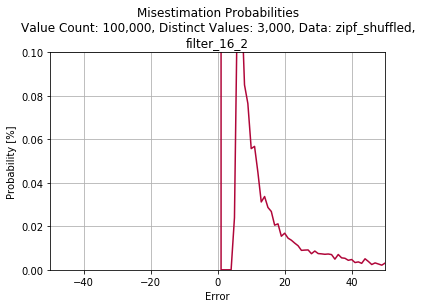

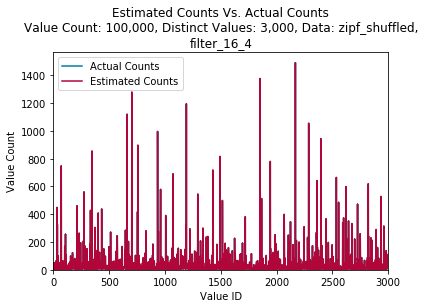

max error: 13
max relative error: 216.666666667%
Estimation Technique: filter_16_4
Sample Size: 3000000
Mean Error: 0.10094
Mean Squared Error: 31.734216
Column Size [kB](uint16_t): 200.0



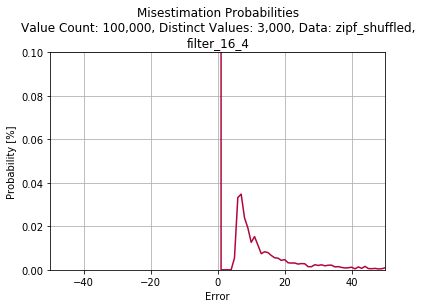

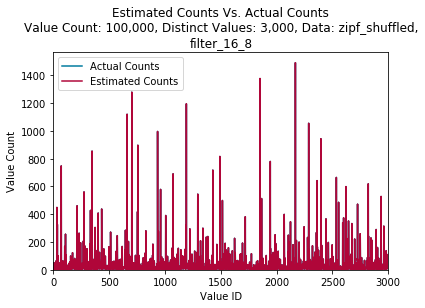

max error: 0
max relative error: 0%
Estimation Technique: filter_16_8
Sample Size: 3000000
Mean Error: 0.006123
Mean Squared Error: 2.28847433333
Column Size [kB](uint16_t): 200.0



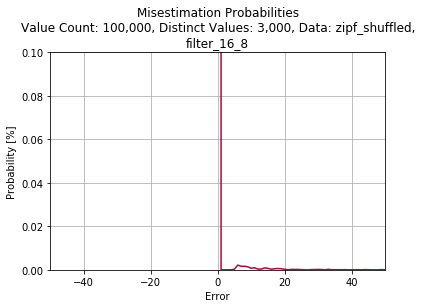

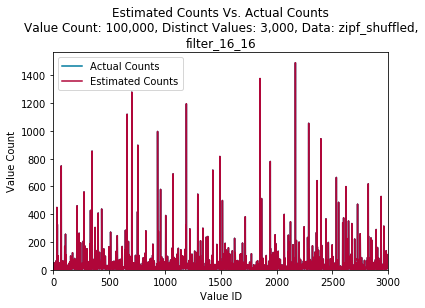

max error: 0
max relative error: 0%
Estimation Technique: filter_16_16
Sample Size: 3000000
Mean Error: 5.7e-05
Mean Squared Error: 0.002015
Column Size [kB](uint16_t): 200.0



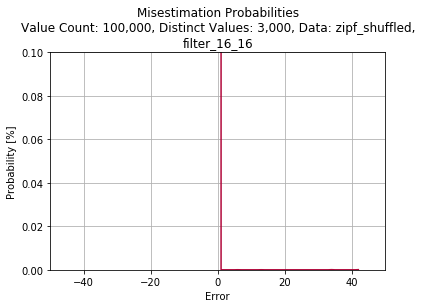

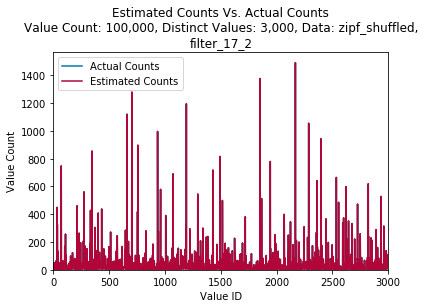

max error: 130
max relative error: 1857.14285714%
Estimation Technique: filter_17_2
Sample Size: 3000000
Mean Error: 0.19306
Mean Squared Error: 59.205974
Column Size [kB](uint16_t): 200.0



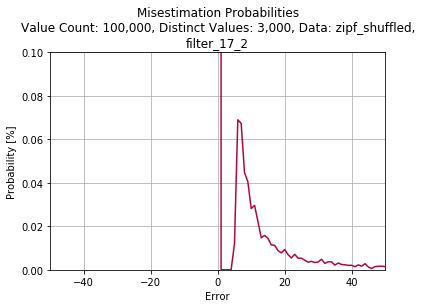

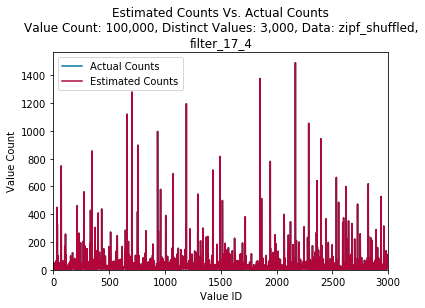

max error: 47
max relative error: 340.0%
Estimation Technique: filter_17_4
Sample Size: 3000000
Mean Error: 0.059881
Mean Squared Error: 22.9500043333
Column Size [kB](uint16_t): 200.0



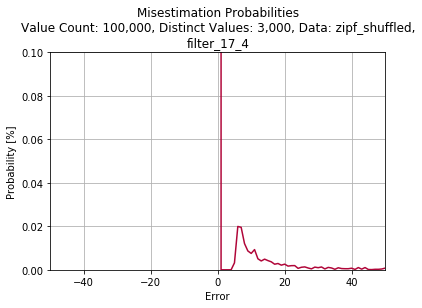

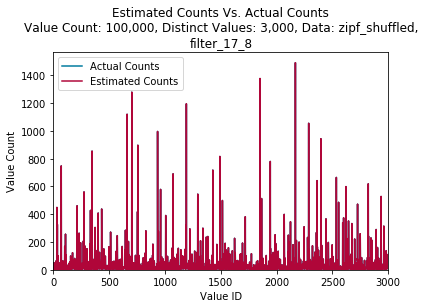

max error: 0
max relative error: 0%
Estimation Technique: filter_17_8
Sample Size: 3000000
Mean Error: 0.00212333333333
Mean Squared Error: 0.194924
Column Size [kB](uint16_t): 200.0



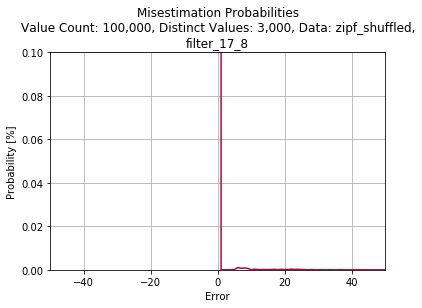

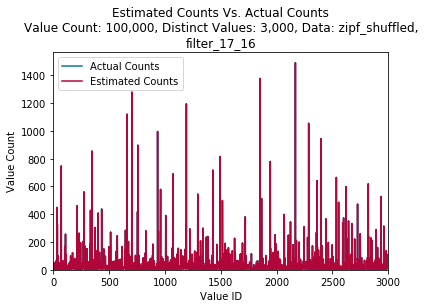

max error: 0
max relative error: 0%
Estimation Technique: filter_17_16
Sample Size: 3000000
Mean Error: 9.5e-05
Mean Squared Error: 0.003125
Column Size [kB](uint16_t): 200.0



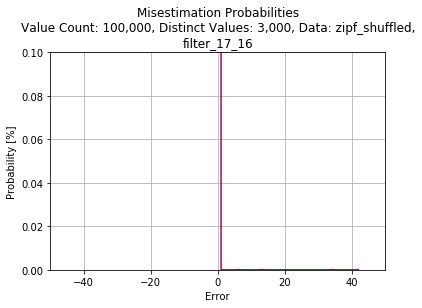

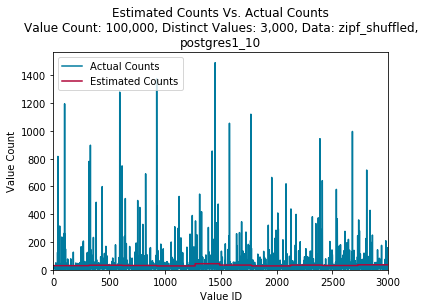

max error: 1447
max relative error: 780.0%
Estimation Technique: postgres1_10
Sample Size: 3000
Mean Error: 34.0803333333
Mean Squared Error: 8169.01833333
Column Size [kB](uint16_t): 200.0



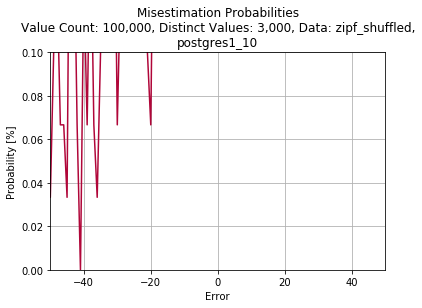

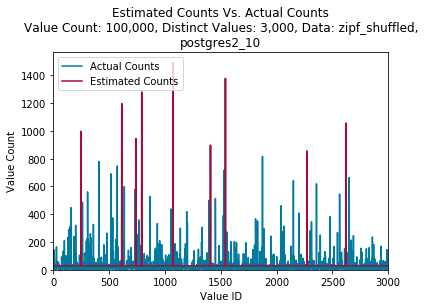

max error: 787
max relative error: 480.0%
Estimation Technique: postgres2_10
Sample Size: 3000
Mean Error: 28.3566666667
Mean Squared Error: 4099.66066667
Column Size [kB](uint16_t): 200.0



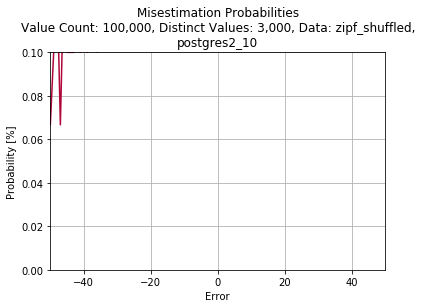

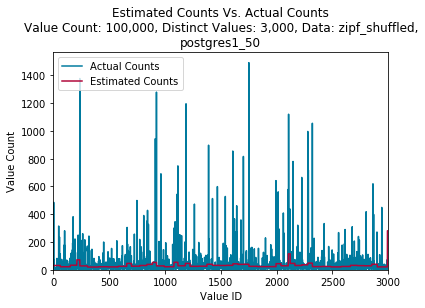

max error: 1451
max relative error: 3022.22222222%
Estimation Technique: postgres1_50
Sample Size: 3000
Mean Error: 32.9653333333
Mean Squared Error: 8112.73733333
Column Size [kB](uint16_t): 200.0



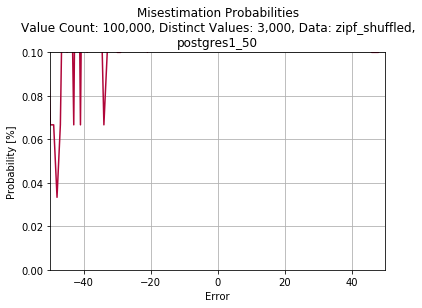

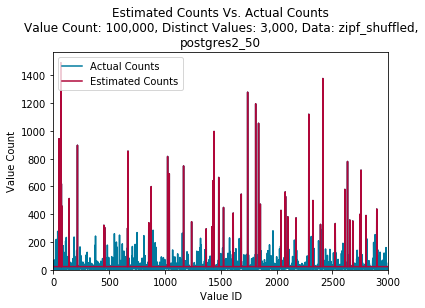

max error: 267
max relative error: 360.0%
Estimation Technique: postgres2_50
Sample Size: 3000
Mean Error: 19.0266666667
Mean Squared Error: 1167.63266667
Column Size [kB](uint16_t): 200.0



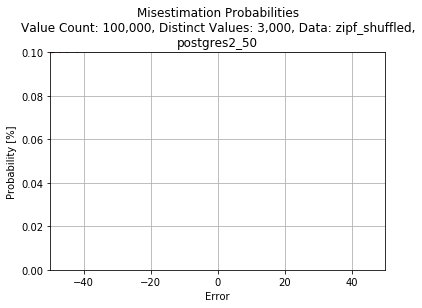

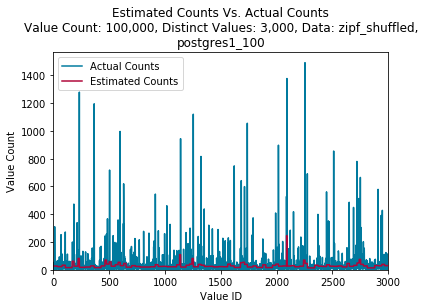

max error: 1421
max relative error: 3414.28571429%
Estimation Technique: postgres1_100
Sample Size: 3000
Mean Error: 31.6123333333
Mean Squared Error: 8000.259
Column Size [kB](uint16_t): 200.0



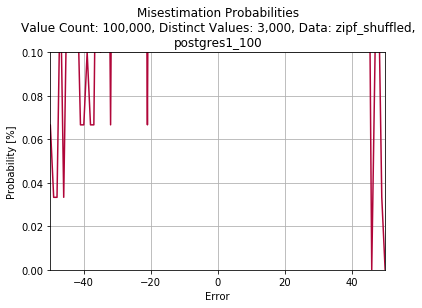

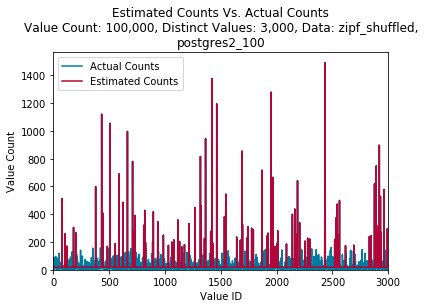

max error: 141
max relative error: 280.0%
Estimation Technique: postgres2_100
Sample Size: 3000
Mean Error: 13.921
Mean Squared Error: 530.070333333
Column Size [kB](uint16_t): 200.0



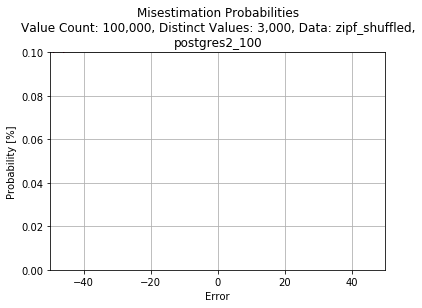

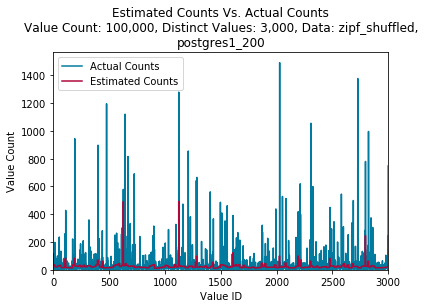

max error: 1393
max relative error: 4000.0%
Estimation Technique: postgres1_200
Sample Size: 3000
Mean Error: 29.1293333333
Mean Squared Error: 7920.13466667
Column Size [kB](uint16_t): 200.0



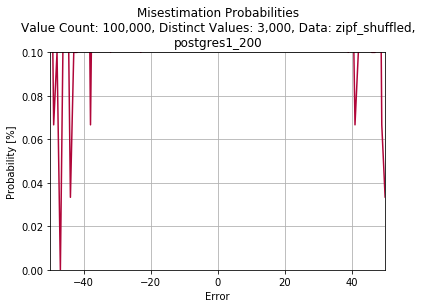

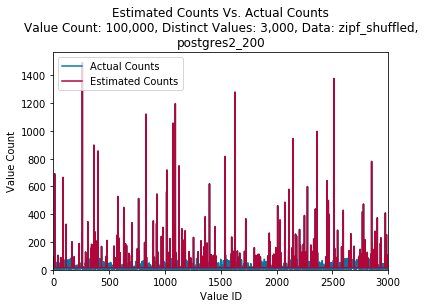

max error: 68
max relative error: 220.0%
Estimation Technique: postgres2_200
Sample Size: 3000
Mean Error: 9.50233333333
Mean Squared Error: 203.437666667
Column Size [kB](uint16_t): 200.0



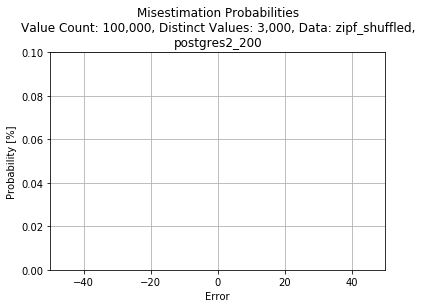

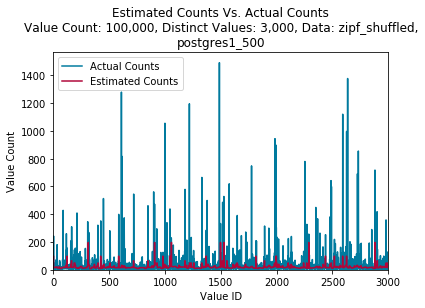

max error: 1472
max relative error: 1300.0%
Estimation Technique: postgres1_500
Sample Size: 3000
Mean Error: 26.1403333333
Mean Squared Error: 7643.671
Column Size [kB](uint16_t): 200.0



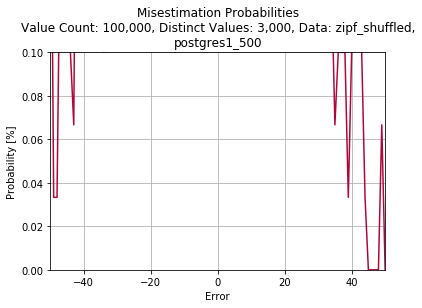

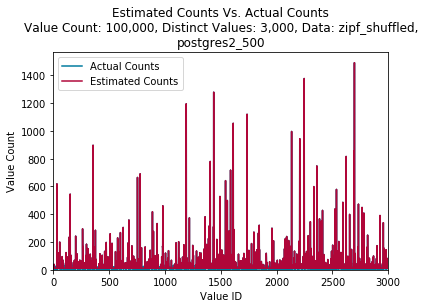

max error: 23
max relative error: 140.0%
Estimation Technique: postgres2_500
Sample Size: 3000
Mean Error: 4.467
Mean Squared Error: 39.6796666667
Column Size [kB](uint16_t): 200.0



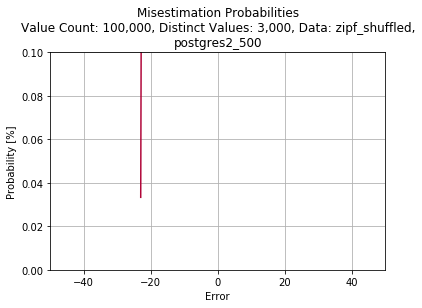

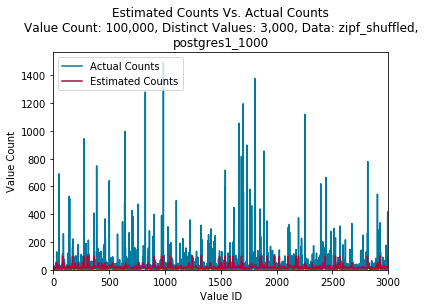

max error: 1393
max relative error: 716.666666667%
Estimation Technique: postgres1_1000
Sample Size: 3000
Mean Error: 24.1556666667
Mean Squared Error: 7841.161
Column Size [kB](uint16_t): 200.0



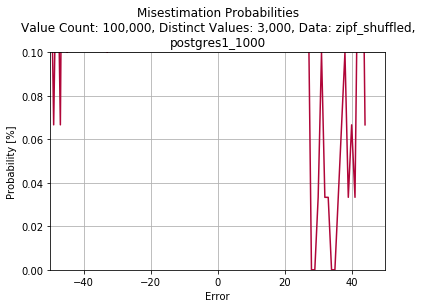

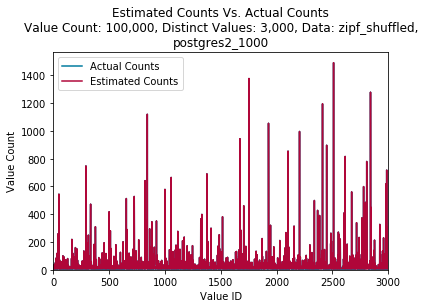

max error: 8
max relative error: 80.0%
Estimation Technique: postgres2_1000
Sample Size: 3000
Mean Error: 1.72033333333
Mean Squared Error: 6.71433333333
Column Size [kB](uint16_t): 200.0



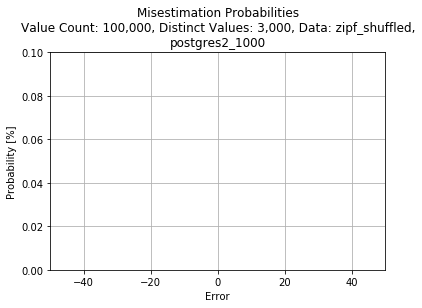

Estimation Technique  Memory Consumption [Byte]  Mean Error  \
0               uniform                        4.0    0.000000   
1          postgres1_10                       40.0    0.000000   
2          postgres1_50                      200.0    0.000000   
3         postgres1_100                      400.0    0.000000   
4          postgres2_10                       40.0    0.000000   
5          postgres2_50                      200.0    0.000000   
6         postgres2_100                      400.0    0.000000   
7           filter_14_4                    12288.0    0.375210   
8           filter_14_8                    20480.0    0.023892   
9          filter_14_16                    36864.0    0.000088   
10          filter_15_2                    16384.0    0.747670   
11          filter_15_4                    24576.0    0.186780   
12          filter_15_8                    40960.0    0.011594   
13         filter_15_16                    73728.0    0.000154   
14          filter_16_2                    32768.0    0.374616   
15          filter_16_4                    49152.0    0.095304   
16          filter_16_8                    81920.0    0.006226   
17         filter_16_16                   147456.0    0.000154   
18          filter_17_2                    65536.0    0.188144   
19          filter_17_4                    98304.0    0.050314   
20          filter_17_8                   163840.0    0.002662   
21         filter_17_16                   294912.0    0.000022   

    Mean Squared Error  
0             0.000000  
1             0.000000  
2             0.000000  
3             0.000000  
4             0.000000  
5             0.000000  
6             0.000000  
7            12.532212  
8             0.788436  
9             0.002904  
10           25.221966  
11            6.244326  
12            0.382602  
13            0.005082  
14           12.499542  
15            3.151566  
16            0.205458  
17            0.005082  
18            6.271914  
19            1.666896  
20            0.087846  
21            0.000726

Estimation Technique  Memory Consumption [Byte]  Mean Error  \
0           filter_14_4                    12288.0    0.375210   
1           filter_14_8                    20480.0    0.023892   
2          filter_14_16                    36864.0    0.000088   
3           filter_15_2                    16384.0    0.747670   
4           filter_15_4                    24576.0    0.186780   
5           filter_15_8                    40960.0    0.011594   
6          filter_15_16                    73728.0    0.000154   
7           filter_16_2                    32768.0    0.374616   
8           filter_16_4                    49152.0    0.095304   
9           filter_16_8                    81920.0    0.006226   
10         filter_16_16                   147456.0    0.000154   
11          filter_17_2                    65536.0    0.188144   
12          filter_17_4                    98304.0    0.050314   
13          filter_17_8                   163840.0    0.002662   
14         filter_17_16                   294912.0    0.000022   

    Mean Squared Error  
0            12.532212  
1             0.788436  
2             0.002904  
3            25.221966  
4             6.244326  
5             0.382602  
6             0.005082  
7            12.499542  
8             3.151566  
9             0.205458  
10            0.005082  
11            6.271914  
12            1.666896  
13            0.087846  
14            0.000726

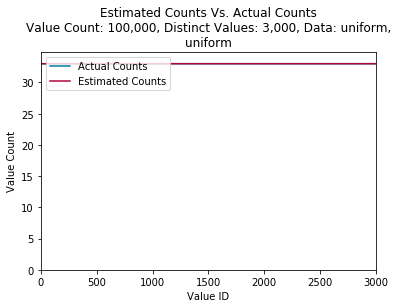

max error: 0
max relative error: 0%
Estimation Technique: uniform
Sample Size: 3000
Mean Error: 0.0
Mean Squared Error: 0.0
Column Size [kB](uint16_t): 200.0



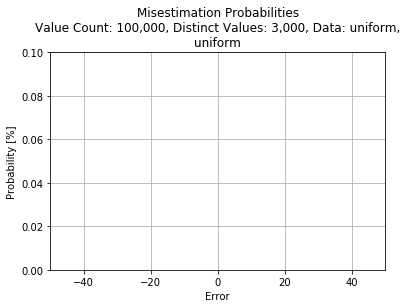

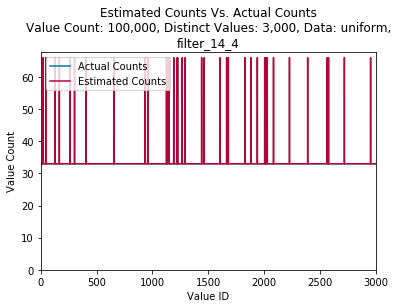

max error: 33
max relative error: 100.0%
Estimation Technique: filter_14_4
Sample Size: 3000000
Mean Error: 0.37521
Mean Squared Error: 12.532212
Column Size [kB](uint16_t): 200.0



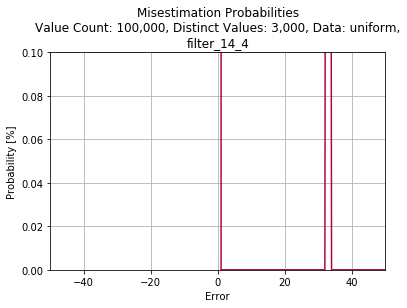

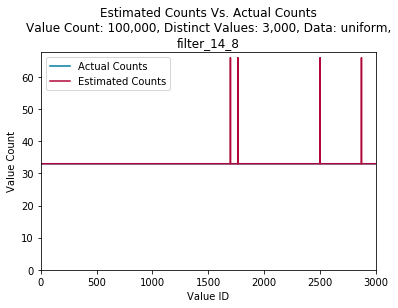

max error: 33
max relative error: 100.0%
Estimation Technique: filter_14_8
Sample Size: 3000000
Mean Error: 0.023892
Mean Squared Error: 0.788436
Column Size [kB](uint16_t): 200.0



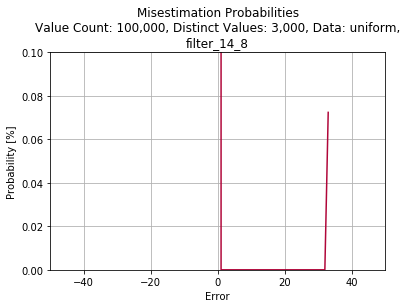

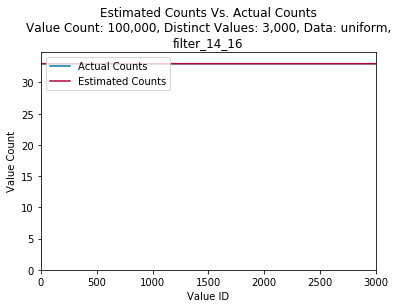

max error: 0
max relative error: 0%
Estimation Technique: filter_14_16
Sample Size: 3000000
Mean Error: 8.8e-05
Mean Squared Error: 0.002904
Column Size [kB](uint16_t): 200.0



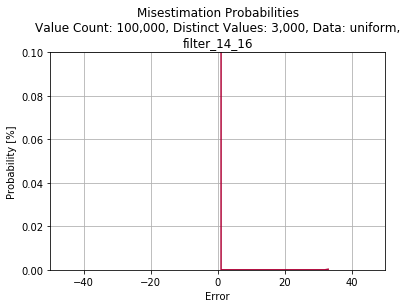

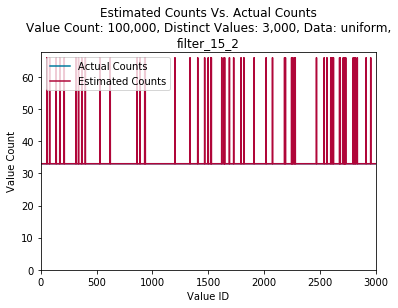

max error: 33
max relative error: 100.0%
Estimation Technique: filter_15_2
Sample Size: 3000000
Mean Error: 0.74767
Mean Squared Error: 25.221966
Column Size [kB](uint16_t): 200.0



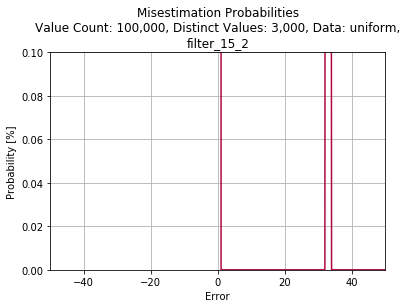

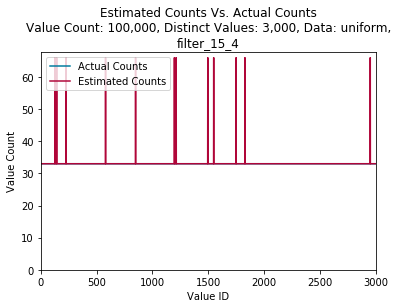

max error: 33
max relative error: 100.0%
Estimation Technique: filter_15_4
Sample Size: 3000000
Mean Error: 0.18678
Mean Squared Error: 6.244326
Column Size [kB](uint16_t): 200.0



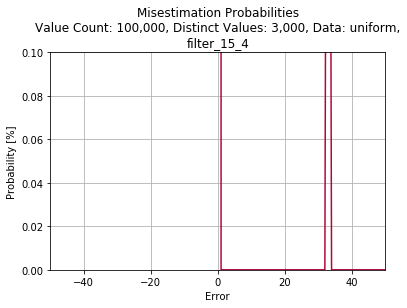

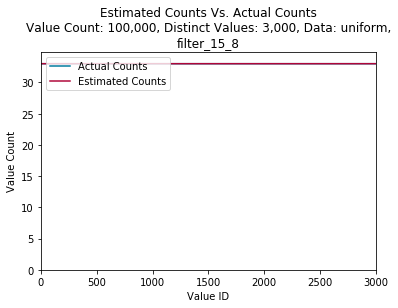

max error: 0
max relative error: 0%
Estimation Technique: filter_15_8
Sample Size: 3000000
Mean Error: 0.011594
Mean Squared Error: 0.382602
Column Size [kB](uint16_t): 200.0



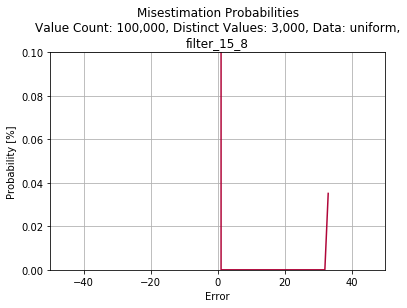

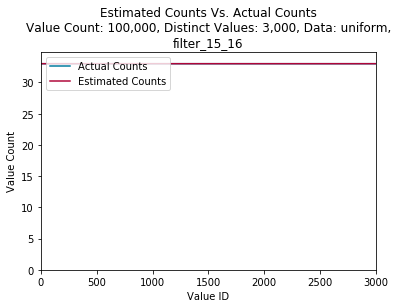

max error: 0
max relative error: 0%
Estimation Technique: filter_15_16
Sample Size: 3000000
Mean Error: 0.000154
Mean Squared Error: 0.005082
Column Size [kB](uint16_t): 200.0



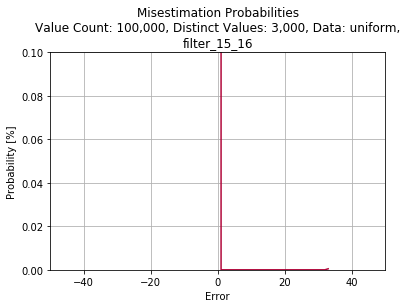

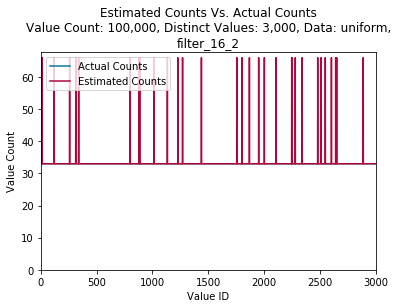

max error: 33
max relative error: 100.0%
Estimation Technique: filter_16_2
Sample Size: 3000000
Mean Error: 0.374616
Mean Squared Error: 12.499542
Column Size [kB](uint16_t): 200.0



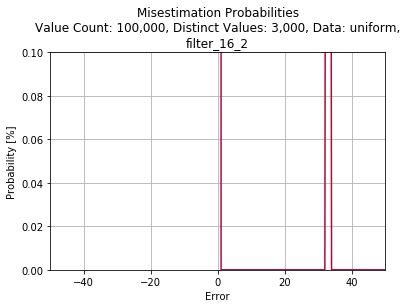

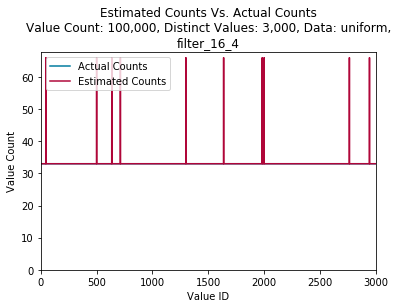

max error: 33
max relative error: 100.0%
Estimation Technique: filter_16_4
Sample Size: 3000000
Mean Error: 0.095304
Mean Squared Error: 3.151566
Column Size [kB](uint16_t): 200.0



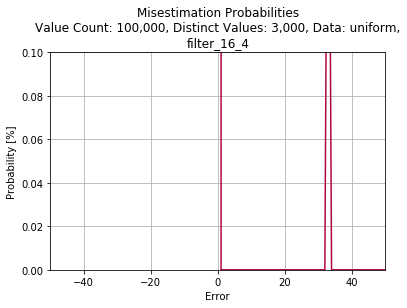

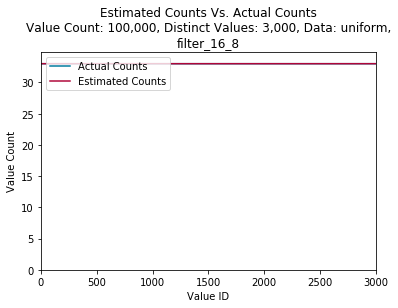

max error: 0
max relative error: 0%
Estimation Technique: filter_16_8
Sample Size: 3000000
Mean Error: 0.006226
Mean Squared Error: 0.205458
Column Size [kB](uint16_t): 200.0



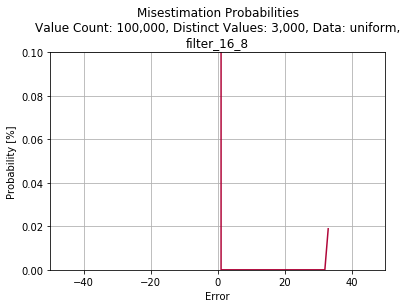

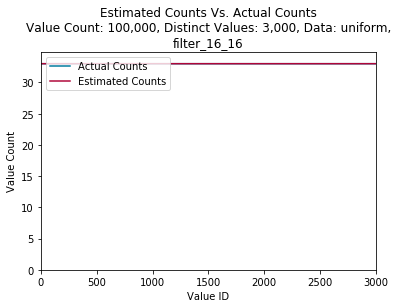

max error: 0
max relative error: 0%
Estimation Technique: filter_16_16
Sample Size: 3000000
Mean Error: 0.000154
Mean Squared Error: 0.005082
Column Size [kB](uint16_t): 200.0



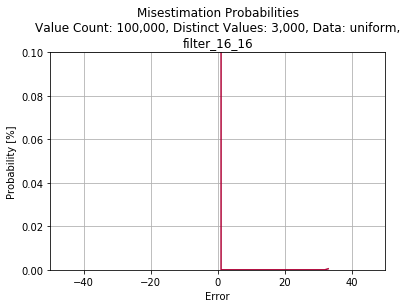

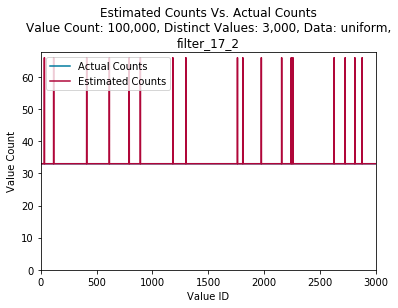

max error: 33
max relative error: 100.0%
Estimation Technique: filter_17_2
Sample Size: 3000000
Mean Error: 0.188144
Mean Squared Error: 6.271914
Column Size [kB](uint16_t): 200.0



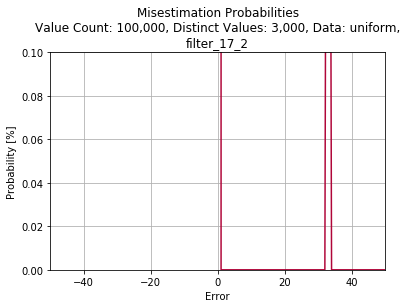

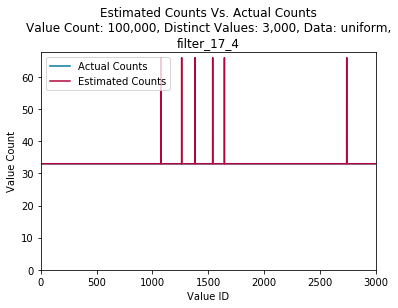

max error: 33
max relative error: 100.0%
Estimation Technique: filter_17_4
Sample Size: 3000000
Mean Error: 0.050314
Mean Squared Error: 1.666896
Column Size [kB](uint16_t): 200.0



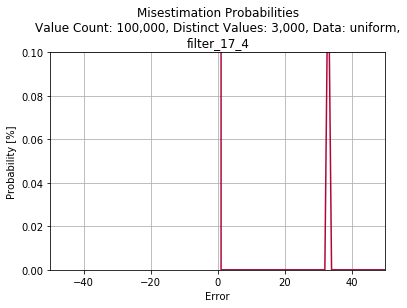

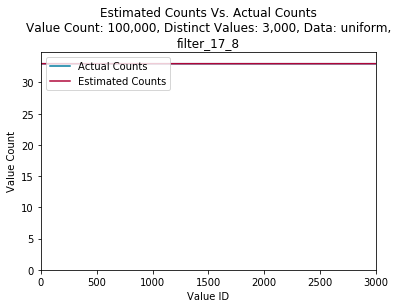

max error: 0
max relative error: 0%
Estimation Technique: filter_17_8
Sample Size: 3000000
Mean Error: 0.002662
Mean Squared Error: 0.087846
Column Size [kB](uint16_t): 200.0



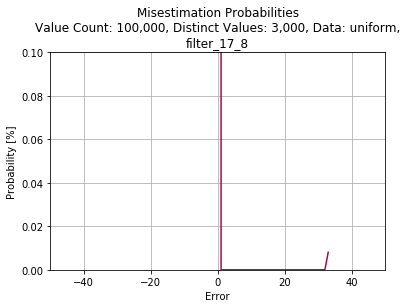

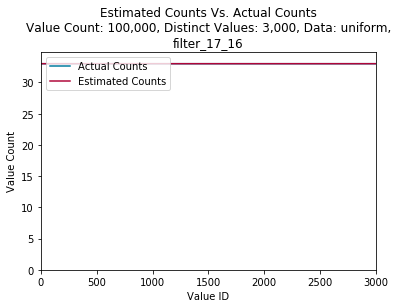

max error: 0
max relative error: 0%
Estimation Technique: filter_17_16
Sample Size: 3000000
Mean Error: 2.2e-05
Mean Squared Error: 0.000726
Column Size [kB](uint16_t): 200.0



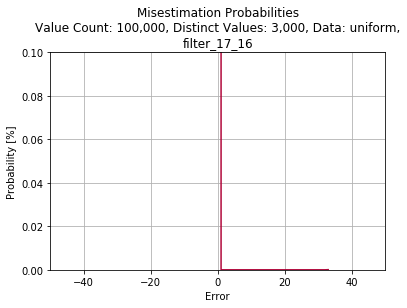

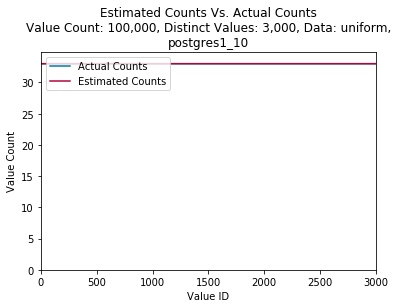

max error: 0
max relative error: 0%
Estimation Technique: postgres1_10
Sample Size: 3000
Mean Error: 0.0
Mean Squared Error: 0.0
Column Size [kB](uint16_t): 200.0



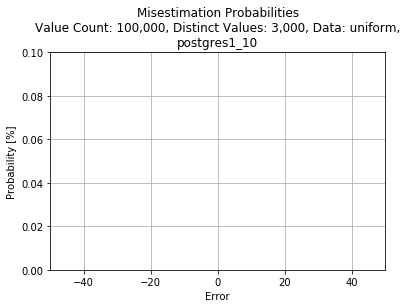

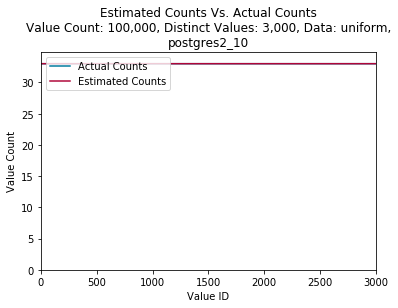

max error: 0
max relative error: 0%
Estimation Technique: postgres2_10
Sample Size: 3000
Mean Error: 0.0
Mean Squared Error: 0.0
Column Size [kB](uint16_t): 200.0



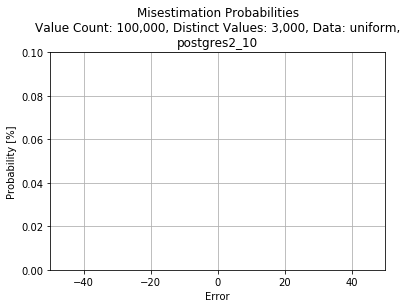

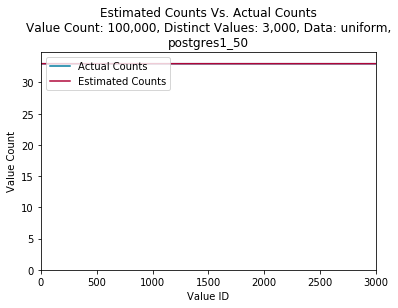

max error: 0
max relative error: 0%
Estimation Technique: postgres1_50
Sample Size: 3000
Mean Error: 0.0
Mean Squared Error: 0.0
Column Size [kB](uint16_t): 200.0



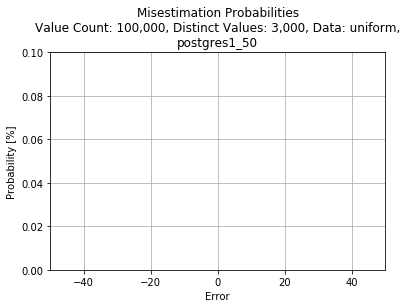

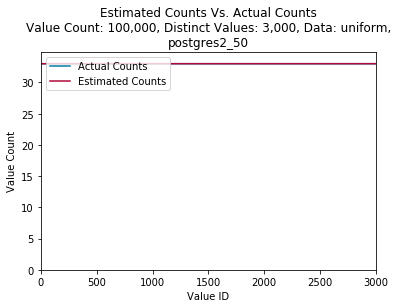

max error: 0
max relative error: 0%
Estimation Technique: postgres2_50
Sample Size: 3000
Mean Error: 0.0
Mean Squared Error: 0.0
Column Size [kB](uint16_t): 200.0



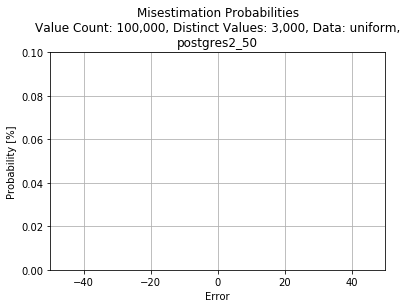

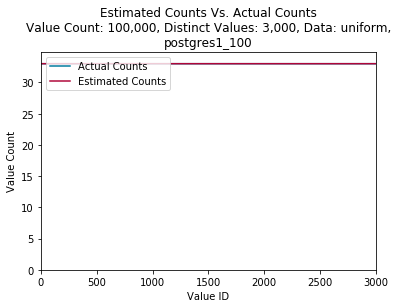

max error: 0
max relative error: 0%
Estimation Technique: postgres1_100
Sample Size: 3000
Mean Error: 0.0
Mean Squared Error: 0.0
Column Size [kB](uint16_t): 200.0



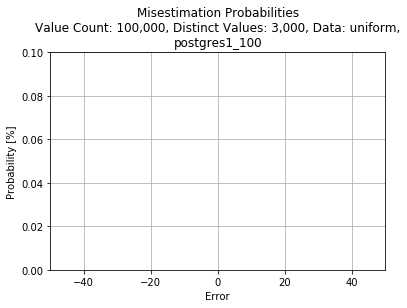

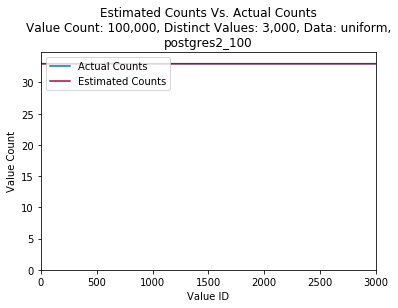

max error: 0
max relative error: 0%
Estimation Technique: postgres2_100
Sample Size: 3000
Mean Error: 0.0
Mean Squared Error: 0.0
Column Size [kB](uint16_t): 200.0



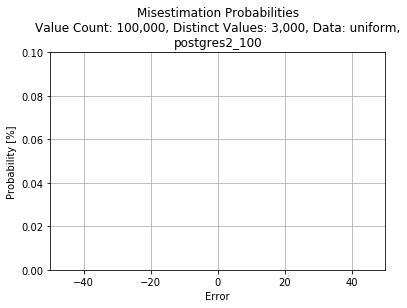

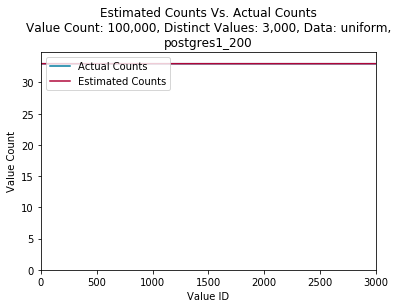

max error: 0
max relative error: 0%
Estimation Technique: postgres1_200
Sample Size: 3000
Mean Error: 0.0
Mean Squared Error: 0.0
Column Size [kB](uint16_t): 200.0



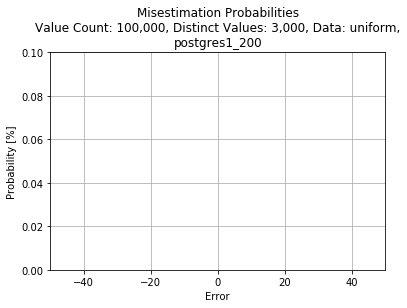

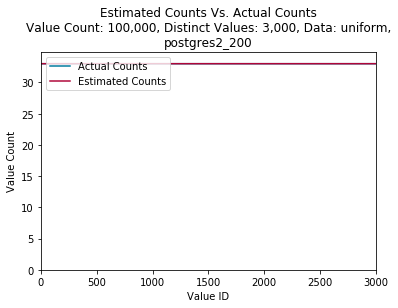

max error: 0
max relative error: 0%
Estimation Technique: postgres2_200
Sample Size: 3000
Mean Error: 0.0
Mean Squared Error: 0.0
Column Size [kB](uint16_t): 200.0



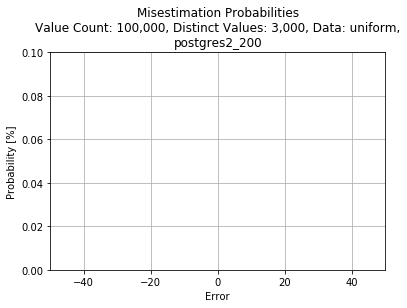

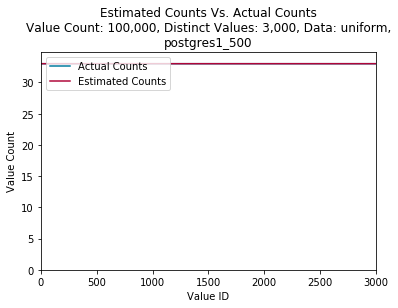

max error: 0
max relative error: 0%
Estimation Technique: postgres1_500
Sample Size: 3000
Mean Error: 0.0
Mean Squared Error: 0.0
Column Size [kB](uint16_t): 200.0



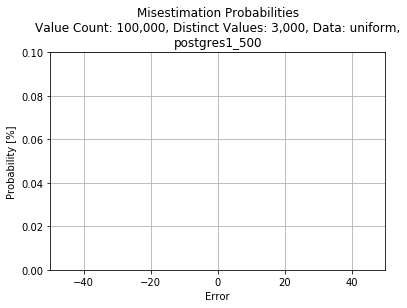

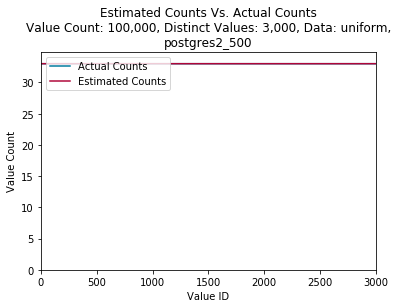

max error: 0
max relative error: 0%
Estimation Technique: postgres2_500
Sample Size: 3000
Mean Error: 0.0
Mean Squared Error: 0.0
Column Size [kB](uint16_t): 200.0



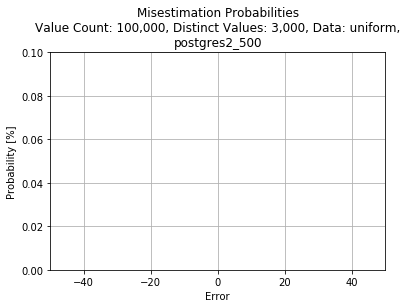

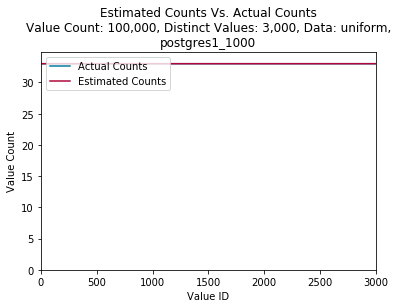

max error: 0
max relative error: 0%
Estimation Technique: postgres1_1000
Sample Size: 3000
Mean Error: 0.0
Mean Squared Error: 0.0
Column Size [kB](uint16_t): 200.0



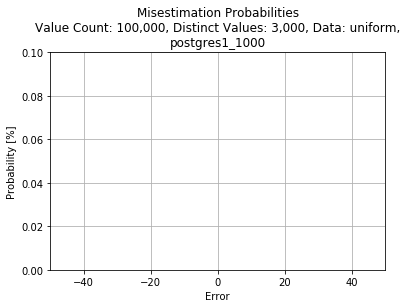

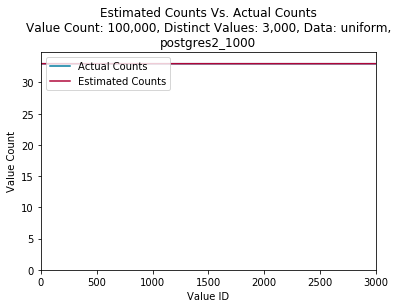

max error: 0
max relative error: 0%
Estimation Technique: postgres2_1000
Sample Size: 3000
Mean Error: 0.0
Mean Squared Error: 0.0
Column Size [kB](uint16_t): 200.0



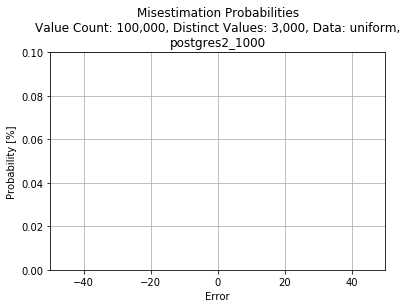

In [9]:
# Generate all plots
data_names = ["normal", "normal_shuffled", "zipf", "zipf_shuffled", "uniform"]
distinct_values = 3000
row_count = 100000
remainder_sizes = [2, 4, 8, 16]
quotient_sizes = [12, 13, 14, 15, 16, 17]
granularities = [10, 50, 100, 200, 500, 1000]

for data_name in data_names:
    complete_estimation_table(data_name, row_count, distinct_values)
    filter_estimation_table(data_name, row_count, distinct_values)

    estimation_example(data_name, row_count, distinct_values, "uniform")
    estimation_evaluation(data_name, row_count, distinct_values, "uniform")

    for estimation_tec in filter_names(quotient_sizes, remainder_sizes):
        estimation_example(data_name, row_count, distinct_values, estimation_tec)  
        estimation_evaluation(data_name, row_count, distinct_values, estimation_tec)

    for granularity in granularities:
        estimation_example(data_name, row_count, distinct_values, "postgres1_" + str(granularity))  
        estimation_evaluation(data_name, row_count, distinct_values, "postgres1_" + str(granularity))
        estimation_example(data_name, row_count, distinct_values, "postgres2_" + str(granularity))  
        estimation_evaluation(data_name, row_count, distinct_values, "postgres2_" + str(granularity))  

Estimation Technique  Memory Consumption [Byte]  Mean Error  \
0               uniform                        1.0    0.761618   
1          postgres1_10                       40.0    0.866816   
2          postgres1_50                      200.0    0.558355   
3         postgres1_100                      400.0    0.548520   
4          postgres2_10                       40.0    0.587012   
5          postgres2_50                      200.0    0.408362   
6         postgres2_100                      400.0    0.298203   
7           filter_17_2                    65536.0    0.184710   
8           filter_17_4                    98304.0    0.047991   
9           filter_17_8                   163840.0    0.002816   
10         filter_17_16                   294912.0    0.000008   

    Mean Squared Error  
0           243.016968  
1           210.545536  
2            73.544195  
3            80.490077  
4            70.244579  
5            18.417861  
6             2.152006  
7            21.793436  
8             7.690392  
9             0.129566  
10            0.000011

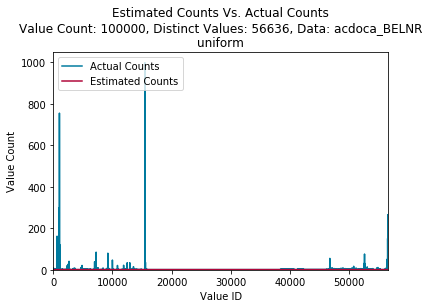

C:\Users\Arne\Anaconda3\lib\site-packages\ipykernel_launcher.py:170: RuntimeWarning: divide by zero encountered in longlong_scalars


max error: 997
max relative error: 99.8997995992%


Estimation Technique  Memory Consumption [Byte]   Mean Error  \
0               uniform                        1.0  1265.272727   
1          postgres1_10                       40.0   850.474747   
2          postgres1_50                      200.0   793.777778   
3         postgres1_100                      400.0   818.878788   
4          postgres2_10                       40.0   240.373737   
5          postgres2_50                      200.0    42.313131   
6         postgres2_100                      400.0  1005.828283   
7           filter_12_2                     2048.0     5.940004   
8           filter_12_4                     3072.0     1.945205   
9           filter_12_8                     5120.0     0.014135   
10         filter_12_16                     9216.0     0.000000   
11          filter_13_2                     4096.0     3.043570   
12          filter_13_4                     6144.0     0.751173   
13          filter_13_8                    10240.0     0.000000   
14         filter_13_16                    18432.0     0.000000   
15          filter_14_2                     8192.0     1.970665   
16          filter_14_4                    12288.0     0.102840   
17          filter_14_8                    20480.0     0.000000   
18         filter_14_16                    36864.0     0.000000   
19          filter_15_2                    16384.0     0.745504   
20          filter_15_4                    24576.0     0.078290   
21          filter_15_8                    40960.0     0.000000   
22         filter_15_16                    73728.0     0.000000   
23          filter_16_2                    32768.0     0.099803   
24          filter_16_4                    49152.0     0.015677   
25          filter_16_8                    81920.0     0.000000   
26         filter_16_16                   147456.0     0.000000   
27          filter_17_2                    65536.0     0.079596   
28          filter_17_4                    98304.0     0.000000   
29          filter_17_8                   163840.0     0.000000   
30         filter_17_16                   294912.0     0.000000   

    Mean Squared Error  
0         9.854754e+06  
1         5.805989e+06  
2         8.585719e+06  
3         9.597039e+06  
4         9.652930e+04  
5         4.460818e+03  
6         1.086644e+07  
7         5.763717e+04  
8         2.108481e+04  
9         1.040111e+01  
10        0.000000e+00  
11        3.017164e+04  
12        6.244608e+03  
13        0.000000e+00  
14        0.000000e+00  
15        2.330037e+04  
16        7.111151e+01  
17        0.000000e+00  
18        0.000000e+00  
19        6.433255e+03  
20        4.973265e+01  
21        0.000000e+00  
22        0.000000e+00  
23        6.631184e+01  
24        1.153577e+01  
25        0.000000e+00  
26        0.000000e+00  
27        5.195836e+01  
28        0.000000e+00  
29        0.000000e+00  
30        0.000000e+00

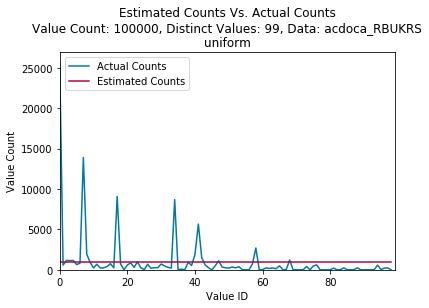

max error: 24618
max relative error: 100400.0%


Estimation Technique  Memory Consumption [Byte]  Mean Error  \
0               uniform                        1.0  152.318217   
1          postgres1_10                       40.0   74.092260   
2          postgres1_50                      200.0   76.394058   
3         postgres1_100                      400.0   76.742768   
4          postgres2_10                       40.0    0.624707   
5          postgres2_50                      200.0    0.419077   
6         postgres2_100                      400.0    0.290852   
7           filter_12_2                     2048.0    4.620151   
8           filter_12_4                     3072.0    0.666059   
9           filter_12_8                     5120.0    0.002439   
10         filter_12_16                     9216.0    0.000008   
11          filter_13_2                     4096.0    2.071438   
12          filter_13_4                     6144.0    0.092652   
13          filter_13_8                    10240.0    0.002247   
14         filter_13_16                    18432.0    0.000004   
15          filter_14_2                     8192.0    0.700449   
16          filter_14_4                    12288.0    0.012101   
17          filter_14_8                    20480.0    0.000539   
18         filter_14_16                    36864.0    0.000002   
19          filter_15_2                    16384.0    0.221490   
20          filter_15_4                    24576.0    0.007221   
21          filter_15_8                    40960.0    0.000262   
22         filter_15_16                    73728.0    0.000001   
23          filter_16_2                    32768.0    0.012383   
24          filter_16_4                    49152.0    0.002581   
25          filter_16_8                    81920.0    0.000110   
26         filter_16_16                   147456.0    0.000003   
27          filter_17_2                    65536.0    0.005948   
28          filter_17_4                    98304.0    0.001909   
29          filter_17_8                   163840.0    0.000062   
30         filter_17_16                   294912.0    0.000003   

    Mean Squared Error  
0         7.365649e+06  
1         5.931743e+06  
2         7.071362e+06  
3         7.220852e+06  
4         2.332291e+00  
5         8.881939e-01  
6         4.597342e-01  
7         4.305762e+05  
8         5.971938e+04  
9         2.309053e-01  
10        1.200000e-05  
11        1.917185e+05  
12        6.290607e+03  
13        6.026070e-01  
14        4.000000e-06  
15        6.286306e+04  
16        1.677009e+00  
17        2.547333e-03  
18        2.000000e-06  
19        1.886154e+04  
20        1.512000e+00  
21        7.833333e-04  
22        1.333333e-06  
23        1.882545e+00  
24        3.055350e-01  
25        3.590000e-04  
26        2.666667e-06  
27        9.111810e-01  
28        4.533980e-01  
29        2.136667e-04  
30        3.333333e-06

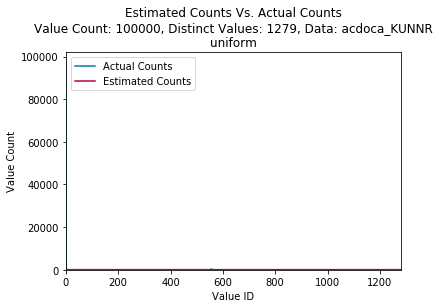

max error: 97021
max relative error: 7700.0%


Estimation Technique  Memory Consumption [Byte]   Mean Error  \
0               uniform                        1.0  6981.857143   
1          postgres1_10                       40.0  4733.428571   
2          postgres1_50                      200.0  5817.142857   
3         postgres1_100                      400.0  6356.000000   
4          postgres2_10                       40.0    75.142857   
5          postgres2_50                      200.0  7031.285714   
6         postgres2_100                      400.0  7031.285714   
7           filter_12_2                     2048.0     5.895320   
8           filter_12_4                     3072.0     2.480324   
9           filter_12_8                     5120.0     0.000000   
10         filter_12_16                     9216.0     0.000000   
11          filter_13_2                     4096.0     5.562347   
12          filter_13_4                     6144.0     0.796368   
13          filter_13_8                    10240.0     0.000000   
14         filter_13_16                    18432.0     0.000000   
15          filter_14_2                     8192.0     2.436043   
16          filter_14_4                    12288.0     0.000000   
17          filter_14_8                    20480.0     0.000000   
18         filter_14_16                    36864.0     0.000000   
19          filter_15_2                    16384.0     0.781307   
20          filter_15_4                    24576.0     0.000000   
21          filter_15_8                    40960.0     0.000000   
22         filter_15_16                    73728.0     0.000000   
23          filter_16_2                    32768.0     0.000000   
24          filter_16_4                    49152.0     0.000000   
25          filter_16_8                    81920.0     0.000000   
26         filter_16_16                   147456.0     0.000000   
27          filter_17_2                    65536.0     0.000000   
28          filter_17_4                    98304.0     0.000000   
29          filter_17_8                   163840.0     0.000000   
30         filter_17_16                   294912.0     0.000000   

    Mean Squared Error  
0         7.362731e+07  
1         5.215630e+07  
2         9.886502e+07  
3         1.101364e+08  
4         2.124957e+04  
5         1.230663e+08  
6         1.230663e+08  
7         7.652841e+04  
8         2.393158e+04  
9         0.000000e+00  
10        0.000000e+00  
11        7.056280e+04  
12        4.288007e+03  
13        0.000000e+00  
14        0.000000e+00  
15        2.323954e+04  
16        0.000000e+00  
17        0.000000e+00  
18        0.000000e+00  
19        4.206910e+03  
20        0.000000e+00  
21        0.000000e+00  
22        0.000000e+00  
23        0.000000e+00  
24        0.000000e+00  
25        0.000000e+00  
26        0.000000e+00  
27        0.000000e+00  
28        0.000000e+00  
29        0.000000e+00  
30        0.000000e+00

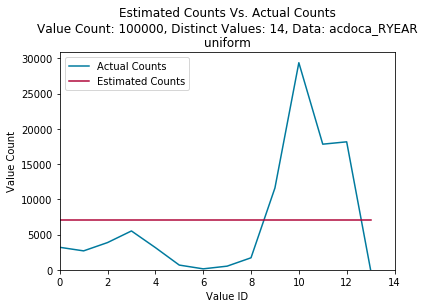

max error: 22361
max relative error: 5108.14814815%


Estimation Technique  Memory Consumption [Byte]  Mean Error  \
0               uniform                        1.0  778.231373   
1          postgres1_10                       40.0  388.941176   
2          postgres1_50                      200.0  388.525490   
3         postgres1_100                      400.0  388.721569   
4          postgres2_10                       40.0    0.211765   
5          postgres2_50                      200.0    0.800000   
6         postgres2_100                      400.0    0.603922   
7           filter_12_2                     2048.0    6.101257   
8           filter_12_4                     3072.0    1.600430   
9           filter_12_8                     5120.0    0.000325   
10         filter_12_16                     9216.0    0.000000   
11          filter_13_2                     4096.0    3.200232   
12          filter_13_4                     6144.0    0.002412   
13          filter_13_8                    10240.0    0.000271   
14         filter_13_16                    18432.0    0.000000   
15          filter_14_2                     8192.0    1.633534   
16          filter_14_4                    12288.0    0.001225   
17          filter_14_8                    20480.0    0.000059   
18         filter_14_16                    36864.0    0.000000   
19          filter_15_2                    16384.0    0.002426   
20          filter_15_4                    24576.0    0.000818   
21          filter_15_8                    40960.0    0.000043   
22         filter_15_16                    73728.0    0.000000   
23          filter_16_2                    32768.0    0.001150   
24          filter_16_4                    49152.0    0.000323   
25          filter_16_8                    81920.0    0.000015   
26         filter_16_16                   147456.0    0.000000   
27          filter_17_2                    65536.0    0.000784   
28          filter_17_4                    98304.0    0.000263   
29          filter_17_8                   163840.0    0.000015   
30         filter_17_16                   294912.0    0.000000   

    Mean Squared Error  
0         3.877694e+07  
1         3.151040e+07  
2         3.738428e+07  
3         3.815396e+07  
4         3.843137e-01  
5         8.000000e-01  
6         6.039216e-01  
7         6.055704e+05  
8         1.588373e+05  
9         1.173333e-03  
10        0.000000e+00  
11        3.176747e+05  
12        7.167667e-03  
13        1.252000e-03  
14        0.000000e+00  
15        1.621465e+05  
16        4.239000e-03  
17        7.833333e-05  
18        0.000000e+00  
19        7.576333e-03  
20        2.906667e-03  
21        5.700000e-05  
22        0.000000e+00  
23        3.799000e-03  
24        1.127667e-03  
25        1.533333e-05  
26        0.000000e+00  
27        2.655667e-03  
28        1.204667e-03  
29        1.533333e-05  
30        0.000000e+00

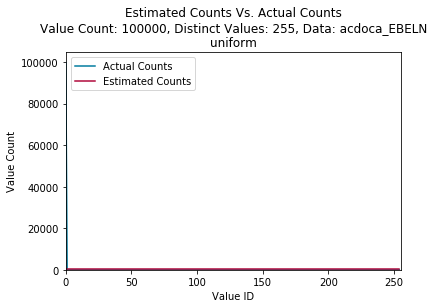

max error: 99244
max relative error: 39100.0%


Estimation Technique  Memory Consumption [Byte]  Mean Error  \
0               uniform                        1.0  167.343343   
1          postgres1_10                       40.0   66.529530   
2          postgres1_50                      200.0   77.108108   
3         postgres1_100                      400.0   79.879880   
4          postgres2_10                       40.0    6.368368   
5          postgres2_50                      200.0    2.733734   
6         postgres2_100                      400.0    1.268268   
7           filter_12_4                     3072.0    1.731782   
8           filter_12_8                     5120.0    0.036735   
9          filter_12_16                     9216.0    0.000029   
10          filter_13_2                     4096.0    3.399971   
11          filter_13_4                     6144.0    0.352643   
12          filter_13_8                    10240.0    0.007352   
13         filter_13_16                    18432.0    0.000000   
14          filter_14_2                     8192.0    1.502150   
15          filter_14_4                    12288.0    0.138543   
16          filter_14_8                    20480.0    0.004508   
17         filter_14_16                    36864.0    0.000000   
18          filter_15_2                    16384.0    0.481320   
19          filter_15_4                    24576.0    0.043883   
20          filter_15_8                    40960.0    0.001566   
21         filter_15_16                    73728.0    0.000000   
22          filter_16_2                    32768.0    0.089365   
23          filter_16_4                    49152.0    0.033385   
24          filter_16_8                    81920.0    0.000751   
25         filter_16_16                   147456.0    0.000000   
26          filter_17_2                    65536.0    0.050524   
27          filter_17_4                    98304.0    0.007281   
28          filter_17_8                   163840.0    0.000482   
29         filter_17_16                   294912.0    0.000000   

    Mean Squared Error  
0         2.808536e+06  
1         1.593833e+06  
2         2.509051e+06  
3         2.657732e+06  
4         2.399199e+02  
5         2.456957e+01  
6         4.615616e+00  
7         5.632684e+04  
8         9.421814e+01  
9         3.226667e-04  
10        1.080811e+05  
11        6.975573e+03  
12        2.541423e-01  
13        0.000000e+00  
14        4.280599e+04  
15        9.111541e+02  
16        1.528463e-01  
17        0.000000e+00  
18        1.384890e+04  
19        6.122333e+01  
20        2.801867e-02  
21        0.000000e+00  
22        3.367112e+02  
23        8.083920e+01  
24        9.715333e-03  
25        0.000000e+00  
26        9.468833e+01  
27        2.397960e-01  
28        6.564000e-03  
29        0.000000e+00

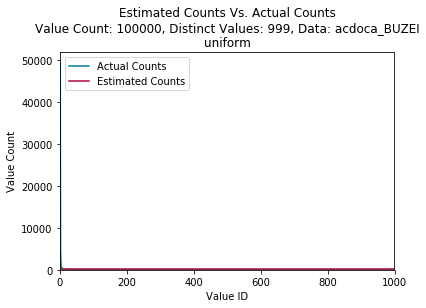

max error: 49216
max relative error: 900.0%


In [8]:
# Generate all plots
column_names =  ["BELNR", "RBUKRS", "KUNNR", "RYEAR", "EBELN", "BUZEI"]
row_count = 100000
remainder_sizes = [2, 4, 8, 16]
quotient_sizes = [12, 13, 14, 15, 16, 17]
granularities = [10, 50, 100, 200, 500, 1000]


for column_name in column_names:
    data_name = "acdoca_" + column_name
    data = get_results("estimation")
    distinct_values = data[(data.data_name == data_name)]["distinct_values"].iloc[0]
    complete_estimation_table(data_name, row_count, distinct_values)
    #filter_estimation_table(data_name, row_count, distinct_values)

    estimation_example(data_name, row_count, distinct_values, "uniform")
    #estimation_evaluation(data_name, row_count, distinct_values, "uniform")

    #for estimation_tec in filter_names(quotient_sizes, remainder_sizes):
    #    estimation_example(data_name, row_count, distinct_values, estimation_tec)  
    #    estimation_evaluation(data_name, row_count, distinct_values, estimation_tec)

    #for granularity in granularities:
    #    estimation_example(data_name, row_count, distinct_values, "postgres1_" + str(granularity))  
    #    estimation_evaluation(data_name, row_count, distinct_values, "postgres1_" + str(granularity))
    #    estimation_example(data_name, row_count, distinct_values, "postgres2_" + str(granularity))  
    #    estimation_evaluation(data_name, row_count, distinct_values, "postgres2_" + str(granularity))  